In [1]:
!pip uninstall dask -y


In [2]:
import pandas as pd

file_path = r'C:\Users\frast\Desktop\Progetti Git\Financial fraud\ps.csv'

df = pd.read_csv(file_path)

print("Shape del dataset:", df.shape)
df.head()


Shape del dataset: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:

print("\nDescriptive Statistics:")
print(df.describe())

numeric_columns = df.select_dtypes(include='number').columns
print("\nNumeric Columns:", list(numeric_columns))

for col in numeric_columns:
    print(f"\nColumn: {col}")
    print(f"Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}")



Descriptive Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.0

In [4]:
# Annotazioni su unità (manuali ma stampabili nel notebook in inglese)
print("\n--- Variable Units (Assumed) ---")
units = {
    "step": "hours (simulated time unit)",
    "amount": "monetary units (e.g., USD)",
    "oldbalanceOrg": "monetary units (e.g., USD)",
    "newbalanceOrig": "monetary units (e.g., USD)",
    "oldbalanceDest": "monetary units (e.g., USD)",
    "newbalanceDest": "monetary units (e.g., USD)"
}
for col, unit in units.items():
    print(f"{col}: {unit}")



--- Variable Units (Assumed) ---
step: hours (simulated time unit)
amount: monetary units (e.g., USD)
oldbalanceOrg: monetary units (e.g., USD)
newbalanceOrig: monetary units (e.g., USD)
oldbalanceDest: monetary units (e.g., USD)
newbalanceDest: monetary units (e.g., USD)


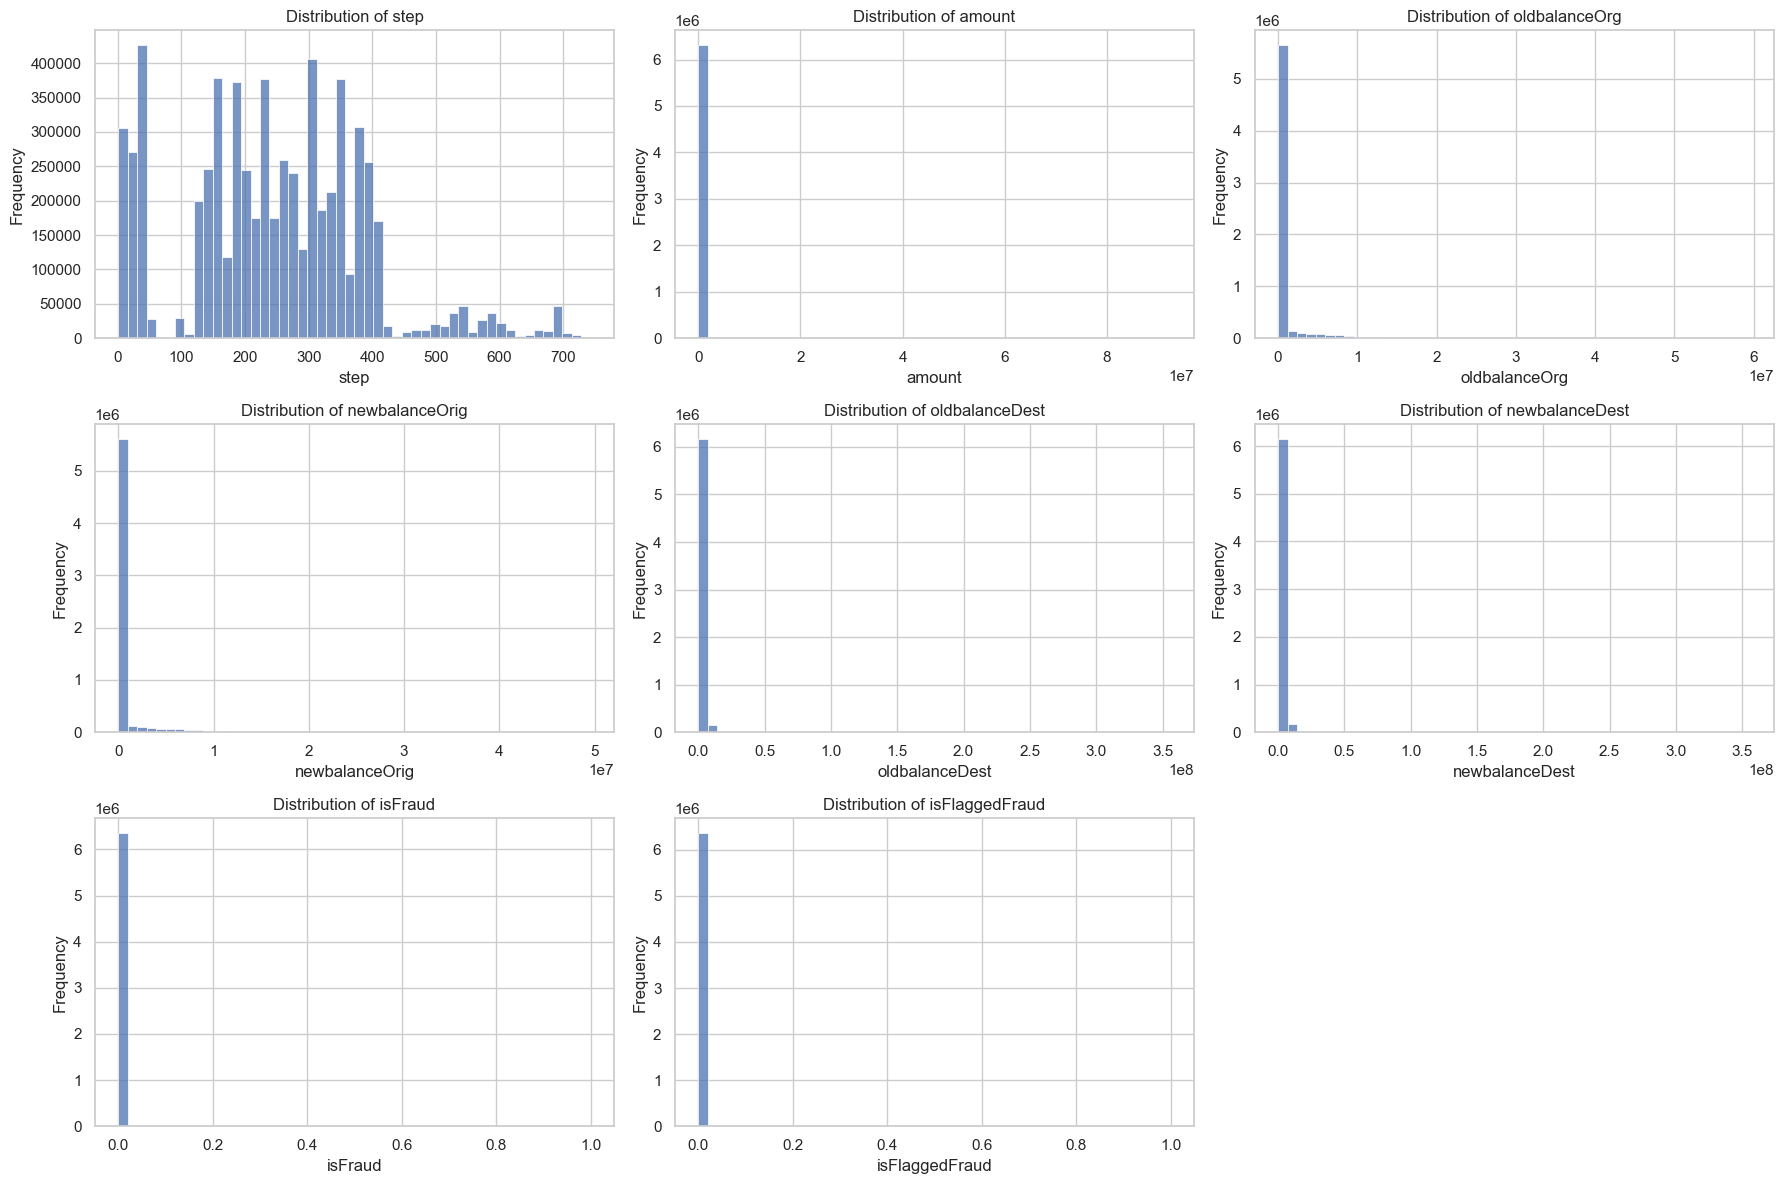

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


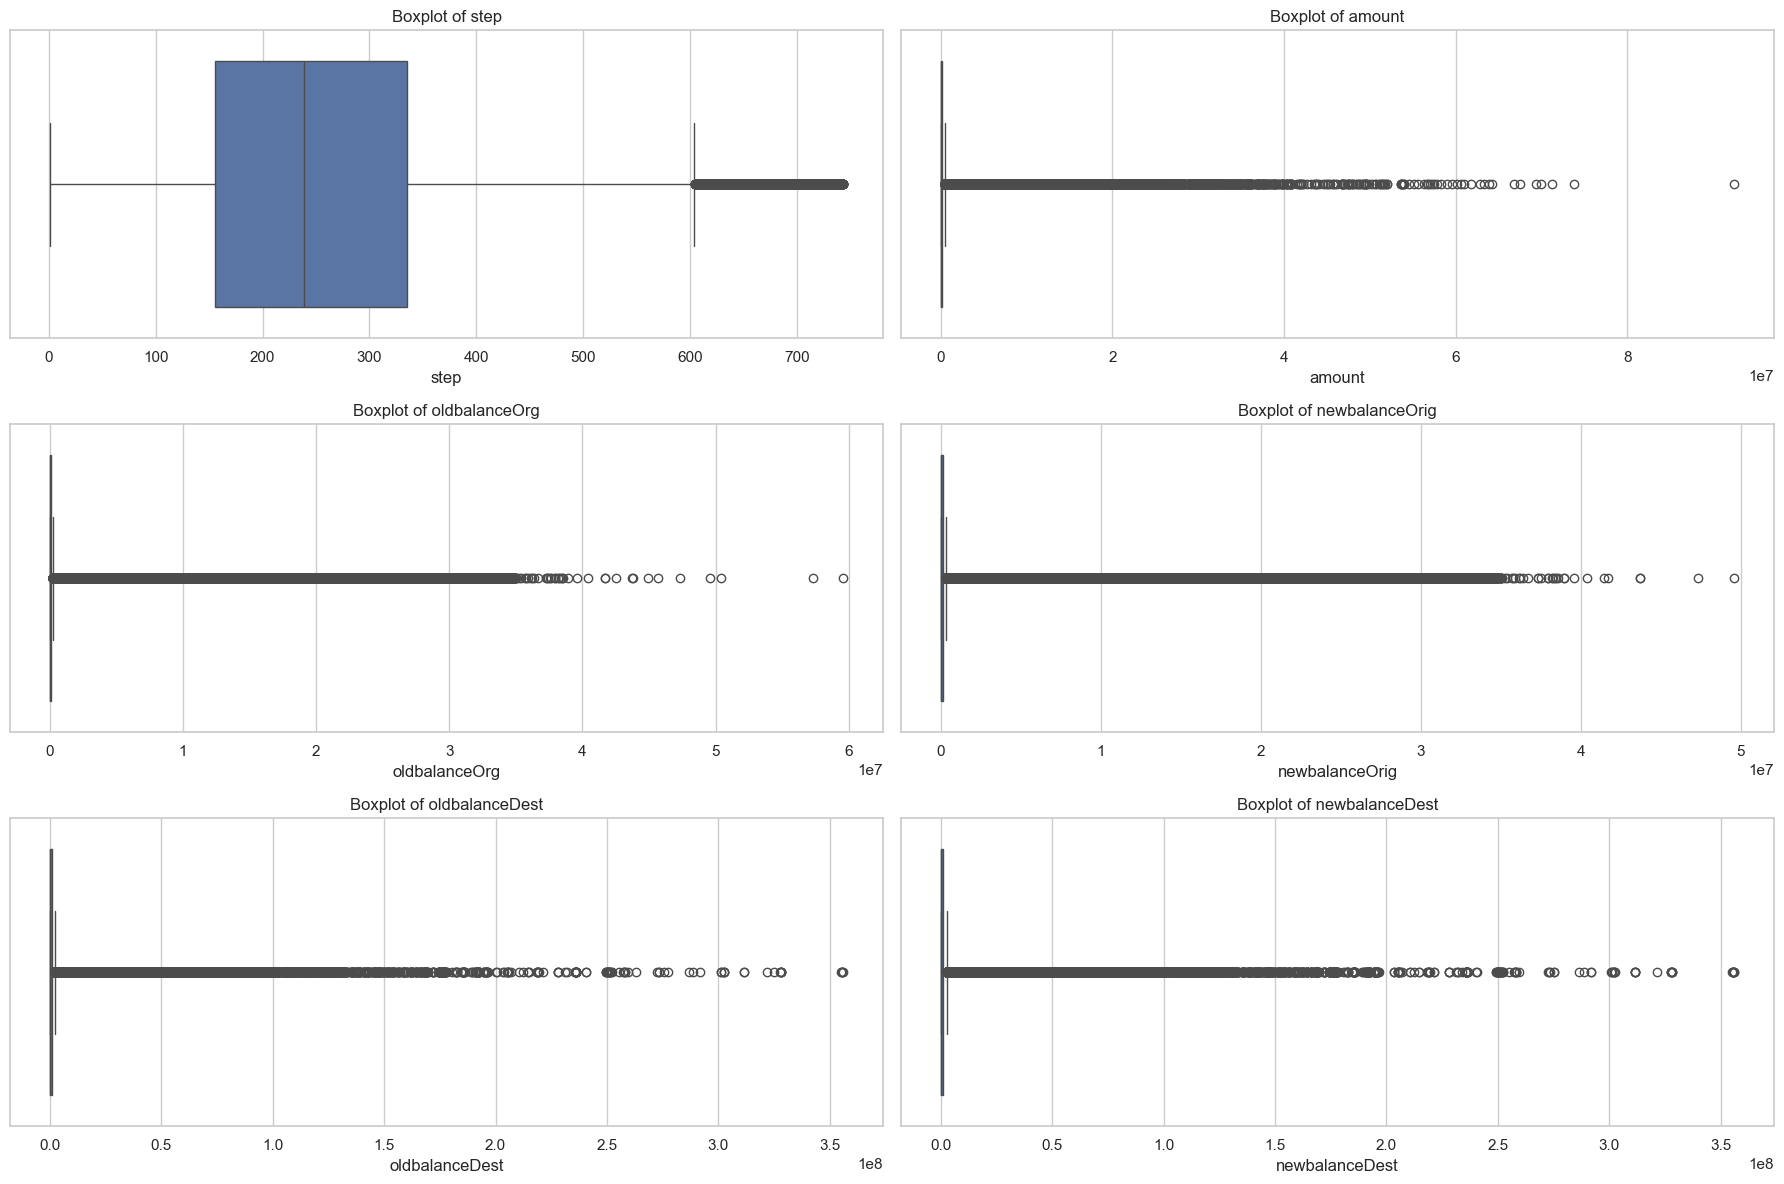

In [6]:
plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_cols[:-2]):  # Escludiamo isFraud e isFlaggedFraud perché binarie
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


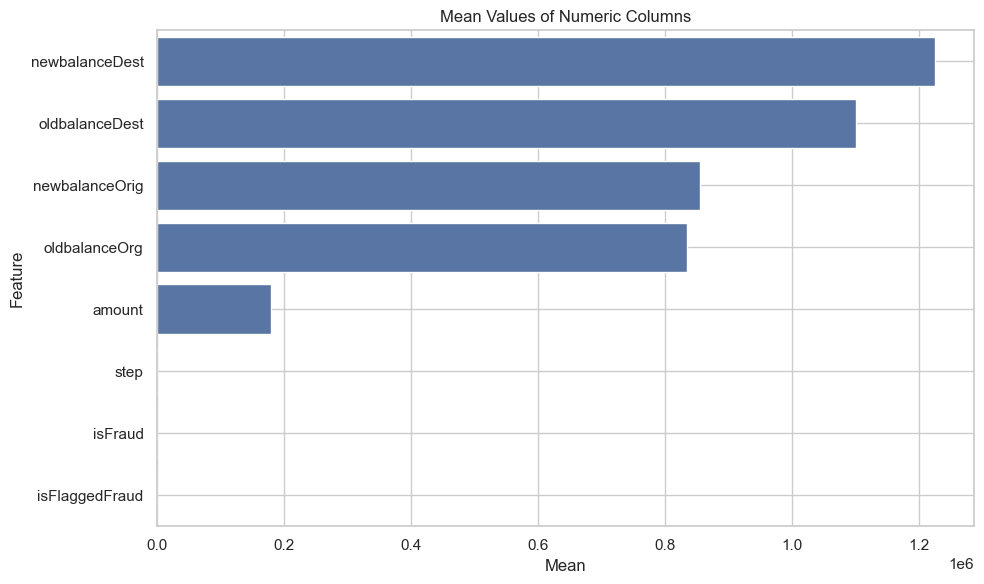

In [7]:
import numpy as np

means = df[numeric_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=means.values, y=means.index, orient='h')
plt.title("Mean Values of Numeric Columns")
plt.xlabel("Mean")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Controlliamo le colonne categoriche
categorical_cols = df.select_dtypes(include='object').columns
print("Categorical columns:", list(categorical_cols))


Categorical columns: ['type', 'nameOrig', 'nameDest']


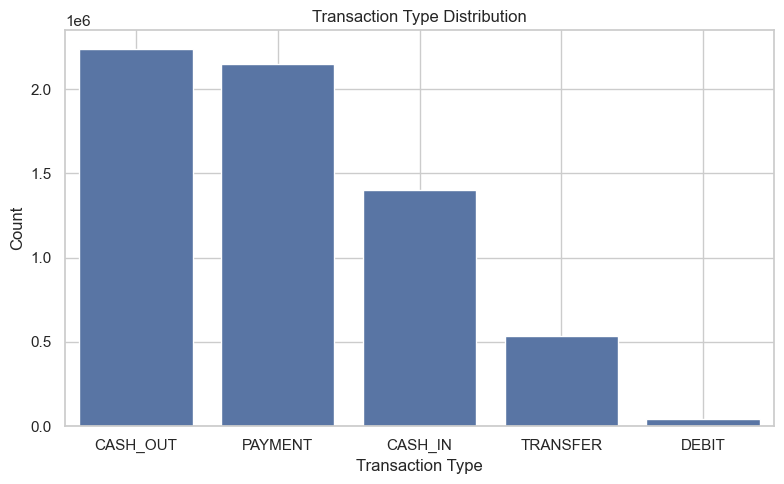

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


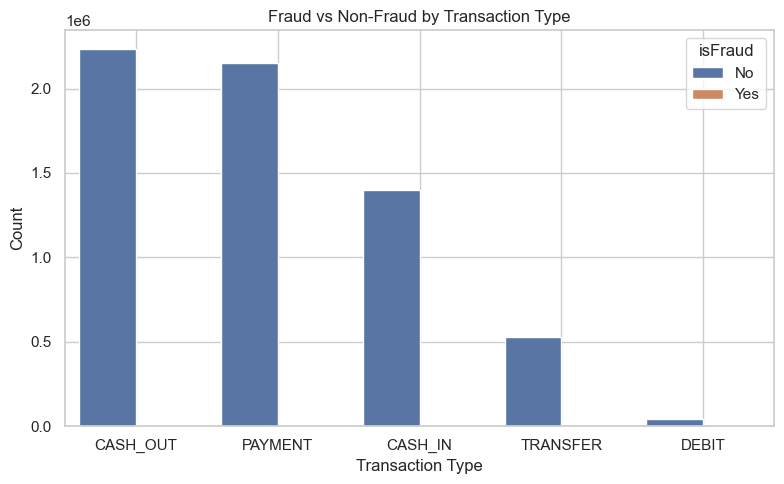

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', hue='isFraud', order=df['type'].value_counts().index)
plt.title("Fraud vs Non-Fraud by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title="isFraud", labels=["No", "Yes"])
plt.grid(True)
plt.tight_layout()
plt.show()


### Accounting Consistency Check

We want to verify if the transactional logic is consistent. Specifically:
- For the sender: `oldbalanceOrg - amount ≈ newbalanceOrig`
- For the receiver: `oldbalanceDest + amount ≈ newbalanceDest`
We define a tolerance threshold to account for small rounding errors.


In [11]:
# Calculate accounting error for the sender
df['errorOrig'] = abs((df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig'])

# Calculate accounting error for the receiver
df['errorDest'] = abs((df['oldbalanceDest'] + df['amount']) - df['newbalanceDest'])

# Set tolerance level
tolerance = 0.01

# Filter transactions with accounting inconsistencies
invalid_orig = df[df['errorOrig'] > tolerance]
invalid_dest = df[df['errorDest'] > tolerance]

# Print counts and rates of inconsistencies
print(f"Transactions with sender-side inconsistencies: {len(invalid_orig)}")
print(f"Transactions with receiver-side inconsistencies: {len(invalid_dest)}")

print(f"Sender-side inconsistency rate: {len(invalid_orig) / len(df):.2%}")
print(f"Receiver-side inconsistency rate: {len(invalid_dest) / len(df):.2%}")


Transactions with sender-side inconsistencies: 5077691
Transactions with receiver-side inconsistencies: 4188647
Sender-side inconsistency rate: 79.81%
Receiver-side inconsistency rate: 65.83%


### Accounting Inconsistencies Observed

A large proportion of transactions in the dataset show accounting inconsistencies, both on the sender and receiver sides. These inconsistencies suggest that:

- The synthetic nature of the dataset includes intentionally simplified or unrealistic balance updates.
- Many transactions appear with zero balances before and after despite non-zero amounts.
- This affects our ability to perform detailed financial logic analysis based solely on balan.

➡️ We must treat balance-related fields with caution when building models or doing feature engineering.


### Examples of Transactions with Accounting Errors

Let's inspect a few inconsistent records to better understand their nature.


In [12]:
# Display some examples of sender inconsistencies
print("\nExamples of sender-side inconsistencies:")
print(invalid_orig[['oldbalanceOrg', 'amount', 'newbalanceOrig', 'errorOrig']].head())

# Display some examples of receiver inconsistencies
print("\nExamples of receiver-side inconsistencies:")
print(invalid_dest[['oldbalanceDest', 'amount', 'newbalanceDest', 'errorDest']].head())



Examples of sender-side inconsistencies:
    oldbalanceOrg     amount  newbalanceOrig  errorOrig
8          2671.0    4024.36             0.0    1353.36
10         4465.0    9644.94             0.0    5179.94
13        10127.0   11633.76             0.0    1506.76
15        15325.0  229133.94             0.0  213808.94
16          450.0    1563.82             0.0    1113.82

Examples of receiver-side inconsistencies:
   oldbalanceDest    amount  newbalanceDest  errorDest
0             0.0   9839.64             0.0    9839.64
1             0.0   1864.28             0.0    1864.28
2             0.0    181.00             0.0     181.00
3         21182.0    181.00             0.0   21363.00
4             0.0  11668.14             0.0   11668.14


In [13]:
# Sender-side inconsistency by type
sender_inconsistency_by_type = df[df['errorOrig'] > 0.01].groupby('type').size() / df.groupby('type').size()

# Receiver-side inconsistency by type
receiver_inconsistency_by_type = df[df['errorDest'] > 0.01].groupby('type').size() / df.groupby('type').size()

# Join and display
inconsistency_df = pd.DataFrame({
    'Sender Inconsistency Rate': sender_inconsistency_by_type,
    'Receiver Inconsistency Rate': receiver_inconsistency_by_type
}).fillna(0).sort_values(by='Sender Inconsistency Rate', ascending=False)

print("\nAccounting inconsistency rate by transaction type:")
print(inconsistency_df)



Accounting inconsistency rate by transaction type:
          Sender Inconsistency Rate  Receiver Inconsistency Rate
type                                                            
CASH_IN                    1.000000                     1.000000
TRANSFER                   0.954726                     0.226701
CASH_OUT                   0.889953                     0.226783
PAYMENT                    0.541899                     1.000000
DEBIT                      0.300782                     0.232453


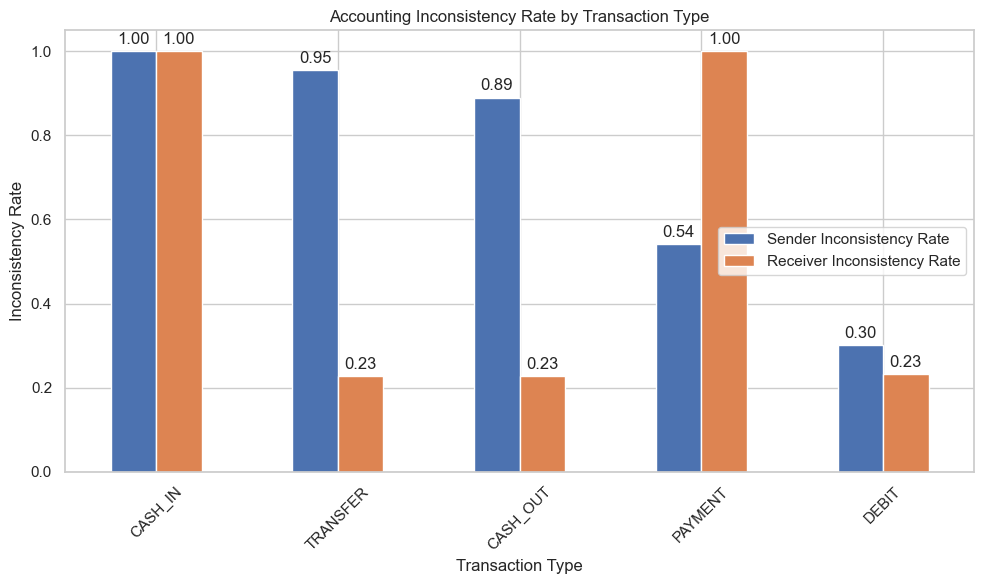

In [14]:
# Reuse on the transaction type plot
ax = inconsistency_df.plot(kind='bar', figsize=(10, 6))
plt.title('Accounting Inconsistency Rate by Transaction Type')
plt.ylabel('Inconsistency Rate')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)
plt.grid(True)

# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()


In [15]:
# Sender-side inconsistency by fraud status
sender_inconsistency_fraud = df[df['errorOrig'] > 0.01].groupby('isFraud').size() / df.groupby('isFraud').size()

# Receiver-side inconsistency by fraud status
receiver_inconsistency_fraud = df[df['errorDest'] > 0.01].groupby('isFraud').size() / df.groupby('isFraud').size()

# Combine and display
fraud_inconsistency_df = pd.DataFrame({
    'Sender Inconsistency Rate': sender_inconsistency_fraud,
    'Receiver Inconsistency Rate': receiver_inconsistency_fraud
}).fillna(0)

print("\nAccounting inconsistency rate by fraud status:")
print(fraud_inconsistency_df)



Accounting inconsistency rate by fraud status:
         Sender Inconsistency Rate  Receiver Inconsistency Rate
isFraud                                                        
0                         0.799075                     0.658442
1                         0.005479                     0.564958


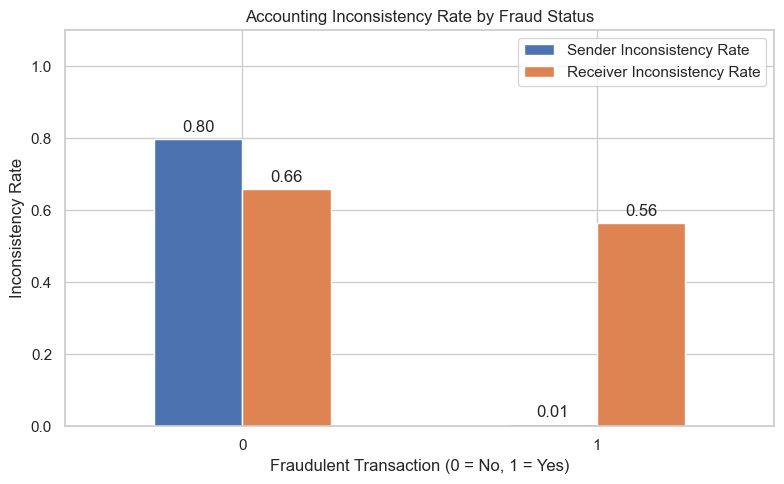

In [16]:
import matplotlib.pyplot as plt

# Data for fraud inconsistency
fraud_inconsistency_df = pd.DataFrame({
    'Sender Inconsistency Rate': df[df['errorOrig'] > 0.01].groupby('isFraud').size() / df.groupby('isFraud').size(),
    'Receiver Inconsistency Rate': df[df['errorDest'] > 0.01].groupby('isFraud').size() / df.groupby('isFraud').size()
}).fillna(0)

# Plotting
ax = fraud_inconsistency_df.plot(kind='bar', figsize=(8, 5))
plt.title('Accounting Inconsistency Rate by Fraud Status')
plt.ylabel('Inconsistency Rate')
plt.xlabel('Fraudulent Transaction (0 = No, 1 = Yes)')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.grid(True, axis='y')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import chi2_contingency

# Create binary flags for inconsistencies
df['sender_inconsistent'] = df['errorOrig'] > 0.01
df['receiver_inconsistent'] = df['errorDest'] > 0.01

# Cross-tabulation: sender-side inconsistency vs type
sender_table = pd.crosstab(df['type'], df['sender_inconsistent'])

# Chi-square test
chi2_sender, p_sender, dof_sender, _ = chi2_contingency(sender_table)

print("Chi-square test for sender-side inconsistency vs transaction type")
print(f"Chi2 statistic: {chi2_sender:.4f}")
print(f"p-value: {p_sender:.4e}")
print(f"Degrees of freedom: {dof_sender}")


Chi-square test for sender-side inconsistency vs transaction type
Chi2 statistic: 1491996.4803
p-value: 0.0000e+00
Degrees of freedom: 4


In [18]:
# Cross-tabulation: receiver-side inconsistency vs type
receiver_table = pd.crosstab(df['type'], df['receiver_inconsistent'])

# Chi-square test
chi2_receiver, p_receiver, dof_receiver, _ = chi2_contingency(receiver_table)

print("\nChi-square test for receiver-side inconsistency vs transaction type")
print(f"Chi2 statistic: {chi2_receiver:.4f}")
print(f"p-value: {p_receiver:.4e}")
print(f"Degrees of freedom: {dof_receiver}")



Chi-square test for receiver-side inconsistency vs transaction type
Chi2 statistic: 4170132.6194
p-value: 0.0000e+00
Degrees of freedom: 4


### Interpretation of Accounting Inconsistencies by Transaction Type

- **CASH_IN and PAYMENT** transactions show a 100% inconsistency rate on the receiver side. In all these transactions, the `newbalanceDest` does not reflect the incoming transfer amount.
  - This suggests that the destination balance fields are not updated in the dataset for these types, possibly by design.

- **CASH_OUT and TRANSFER** transactions show high inconsistency rates on the sender side (89% and 95% respectively), but relatively low inconsistencies on the receiver side (~23%).
  - This may indicate that the simulation focuses more on updating the receiver's account correctly, while the sender's balance is less consistent.

- **DEBIT** transactions are comparatively more consistent, although around 30% still contain discrepancies.

### Implications for Modeling

- Balance-related features (`oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`) appear to be unreliable for certain transaction types, especially **CASH_IN** and **PAYMENT**.
  
- Some transaction types may have been artificially simplified in the simulation process, possibly to reduce overfitting risks in machine learning models.

- During feature engineering and model training, it is important to either exclude or treat these balance variables with caution, depending on the transaction type.


### Interpretation of Accounting Inconsistencies by Fraud Status

- The majority of **non-fraudulent transactions (`isFraud = 0`)** show high inconsistency rates:
  - ~80% on the sender side
  - ~66% on the receiver side

- In contrast, **fraudulent transactions (`isFraud = 1`)** exhibit very low sender-side inconsistencies (only ~0.5%), and moderately high receiver-side inconsistencies (~56%).

- This indicates that fraudulent transactions in the dataset are simulated with much more precision on the sender side.

### Implications for Modeling

- Fraudulent transactions are more "accounting-consistent" than legitimate ones, which may be an artifact of the synthetic data generation process.

- The unusually high consistency of `isFraud = 1` transactions on the sender side could make balance-related features potentially predictive, but also potentially misleading due to simulation bias.

- Careful evaluation is needed before relying on balance differences or calculated financial deltas as key features in the model.


In [19]:
# Count unique values per column
unique_counts = df.nunique().sort_values(ascending=False)
print("Unique value counts per column:")
print(unique_counts)


Unique value counts per column:
nameOrig                 6353307
amount                   5316900
errorOrig                4716888
oldbalanceDest           3614697
newbalanceDest           3555499
errorDest                3168699
nameDest                 2722362
newbalanceOrig           2682586
oldbalanceOrg            1845844
step                         743
type                           5
isFraud                        2
isFlaggedFraud                 2
sender_inconsistent            2
receiver_inconsistent          2
dtype: int64


In [20]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])


Missing values per column:
Series([], dtype: int64)


In [21]:
fraud_dist = df['isFraud'].value_counts(normalize=True)
print("Fraud class distribution (%):")
print((fraud_dist * 100).round(4))


Fraud class distribution (%):
isFraud
0    99.8709
1     0.1291
Name: proportion, dtype: float64


In [22]:
print("Number of unique steps (time units):", df['step'].nunique())
print("Estimated days covered:", df['step'].max() / 24)

# Optional: frauds per time unit
fraud_by_time = df.groupby('step')['isFraud'].sum()


Number of unique steps (time units): 743
Estimated days covered: 30.958333333333332


In [23]:
# Transaction count per type and fraud
print("Counts per transaction type and fraud status:")
print(df.groupby(['type', 'isFraud']).size())


Counts per transaction type and fraud status:
type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
dtype: int64


In [24]:
# Auto-codebook
codebook = pd.DataFrame({
    'Data Type': df.dtypes,
    'Unique Values': df.nunique(),
    'Missing Values': df.isnull().sum(),
    'Sample Values': df.apply(lambda x: x.unique()[:5])
})
codebook


,Data Type,Unique Values,Missing Values,Sample Values
step,int64,743,0,"[1, 2, 3, 4, 5]"
type,object,5,0,"[PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN]"
amount,float64,5316900,0,"[9839.64, 1864.28, 181.0, 11668.14, 7817.71]"
nameOrig,object,6353307,0,"[C1231006815, C1666544295, C1305486145, C84008..."
oldbalanceOrg,float64,1845844,0,"[170136.0, 21249.0, 181.0, 41554.0, 53860.0]"
newbalanceOrig,float64,2682586,0,"[160296.36, 19384.72, 0.0, 29885.86, 46042.29]"
nameDest,object,2722362,0,"[M1979787155, M2044282225, C553264065, C389970..."
oldbalanceDest,float64,3614697,0,"[0.0, 21182.0, 41898.0, 10845.0, 5083.0]"
newbalanceDest,float64,3555499,0,"[0.0, 40348.79, 157982.12, 51513.44, 16896.7]"
isFraud,int64,2,0,"[0, 1]"


In [25]:
import pandas as pd
import os

# Definizione del percorso in cui salvare il file
save_path = r'C:\Users\frast\Desktop\Progetti Git\Financial fraud\codebook.csv'

# Definizione delle unità conosciute
known_units = {
    'step': 'hours (simulated)',
    'amount': 'monetary units',
    'oldbalanceOrg': 'monetary units',
    'newbalanceOrig': 'monetary units',
    'oldbalanceDest': 'monetary units',
    'newbalanceDest': 'monetary units',
    'isFraud': 'binary flag (0 = no fraud, 1 = fraud)',
    'isFlaggedFraud': 'binary flag (system rule)'
}

# Costruzione del codebook
codebook = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes.values,
    'Unique Values': df.nunique().values,
    'Missing Values': df.isnull().sum().values,
    'Sample Values': df.apply(lambda x: x.dropna().unique()[:5].tolist()).values,
    'Unit (if known)': [known_units.get(col, '') for col in df.columns]
})

# Salvataggio nel percorso indicato
codebook.to_csv(save_path, index=False)
print(f"Codebook saved to: {save_path}")


Codebook saved to: C:\Users\frast\Desktop\Progetti Git\Financial fraud\codebook.csv


## Dataset Overview: Synthetic Financial Datasets for Fraud Detection

### 1. Context
This dataset contains simulated financial transactions for the purpose of developing and testing fraud detection algorithms. It reflects typical operations found in digital banking environments, including payments, cash-outs, transfers, and deposits. Fraudulent transactions are explicitly labeled via the `isFraud` column.

The dataset includes two fraud-related variables:
- `isFraud`: Indicates whether a transaction was fraudulent (1) or legitimate (0).
- `isFlaggedFraud`: Indicates if a transaction was flagged by a rule-based system (not always overlapping with actual frauds).

### 2. Data Structure
- Total records: *~6 million transactions*
- Each row represents a single financial transaction.
- Includes numerical, categorical, and identifier fields.
- No missing values were found.
- Some transaction types exhibit accounting inconsistencies (discussed in section below).

### 3. Data Types
- Numerical variables: `step`, `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`, `isFraud`, `isFlaggedFraud`
- Categorical variables: `type` (transaction type)
- ID-like variables: `nameOrig`, `nameDest` (user identifiers, not directly meaningful for modeling)

### 4. Units
- `step`: Simulated time unit in hours (1 to 743 → ~31 days)
- `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`: Represent monetary values, assumed to be in consistent currency (e.g., USD)
- `isFraud`, `isFlaggedFraud`: Binary indicators (0 or 1)

### 5. Codebook
A complete codebook has been generated and saved as `codebook.csv`. It contains for each column:
- Data type
- Number of unique values
- Missing values count
- Sample values
- Unit (when known)

### 6. Accounting Inconsistencies
A significant number of transactions exhibit logical inconsistencies in balance updates:
- **Sender-side inconsistency:** 79.8% of transactions have `oldbalanceOrg - amount ≠ newbalanceOrig`
- **Receiver-side inconsistency:** 65.8% of transactions have `oldbalanceDest + amount ≠ newbalanceDest`
- These inconsistencies vary by transaction type. For instance:
  - All `CASH_IN` and `PAYMENT` transactions have receiver-side errors.
  - Most `TRANSFER` and `CASH_OUT` transactions have sender-side inconsistencies.
  - Fraudulent transactions (`isFraud = 1`) are highly consistent on the sender side, suggesting artificial data refinement.

### 7. Implications for Modeling
- Balance-related fields may not be trustworthy for all transaction types.
- Fraudulent transactions are unusually consistent, which may introduce bias.
- Features must be engineered with caution to avoid relying on simulation artifacts.


### Data Transformation

In this step, raw variables are prepared for modeling. The key actions include:

- **Dropping identifiers**: `nameOrig` and `nameDest` are string-based IDs with high cardinality. They do not add value to prediction and are removed.
- **Encoding categorical variables**: The column `type` is encoded using one-hot encoding to preserve all transaction types as separate features.
- **Dropping derived inconsistency columns**: Temporary diagnostic columns (`errorOrig`, `errorDest`, etc.) are removed to avoid data leakage.
- **Creating new features**:
  - `balance_diff_orig`: Difference between `oldbalanceOrg` and `newbalanceOrig`
  - `balance_diff_dest`: Difference between `newbalanceDest` and `oldbalanceDest`


In [26]:
# Drop ID columns
df_transformed = df.drop(columns=['nameOrig', 'nameDest'])

# Drop error and helper columns if present
drop_cols = ['errorOrig', 'errorDest', 'sender_inconsistent', 'receiver_inconsistent']
df_transformed = df_transformed.drop(columns=[col for col in drop_cols if col in df_transformed.columns])

# One-hot encode the 'type' column
df_transformed = pd.get_dummies(df_transformed, columns=['type'], prefix='type')

# Create new features: balance differences
df_transformed['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df_transformed['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']


### Data Integration

Although no external datasets are integrated, internal transformations simulate enrichment:

- `total_activity_orig`: Sum of `oldbalanceOrg`, `amount`, and `balance_diff_orig`
- `origin_empty`: Flag (1/0) for sender having zero balance before and after
- `dest_empty`: Flag (1/0) for receiver having zero balance before and after

These features can help identify suspicious or abnormal patterns.


In [27]:
# Enriched behavioral features
df_transformed['total_activity_orig'] = df['oldbalanceOrg'] + df['amount'] + df_transformed['balance_diff_orig']

# Binary flags for empty balances (potential simulation artifacts)
df_transformed['origin_empty'] = ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0)).astype(int)
df_transformed['dest_empty'] = ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0)).astype(int)


### Missing Data Imputation

No missing values were found in the dataset (`df.isnull().sum()` returned 0 for all columns).  
Therefore, no imputation was necessary.

However, derived features such as balance differences may include artificial zeros or undefined patterns (e.g., zero old and new balance but non-zero amount).  
These should be carefully considered during feature selection.


In [28]:
# Check for missing data
missing_values = df_transformed.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


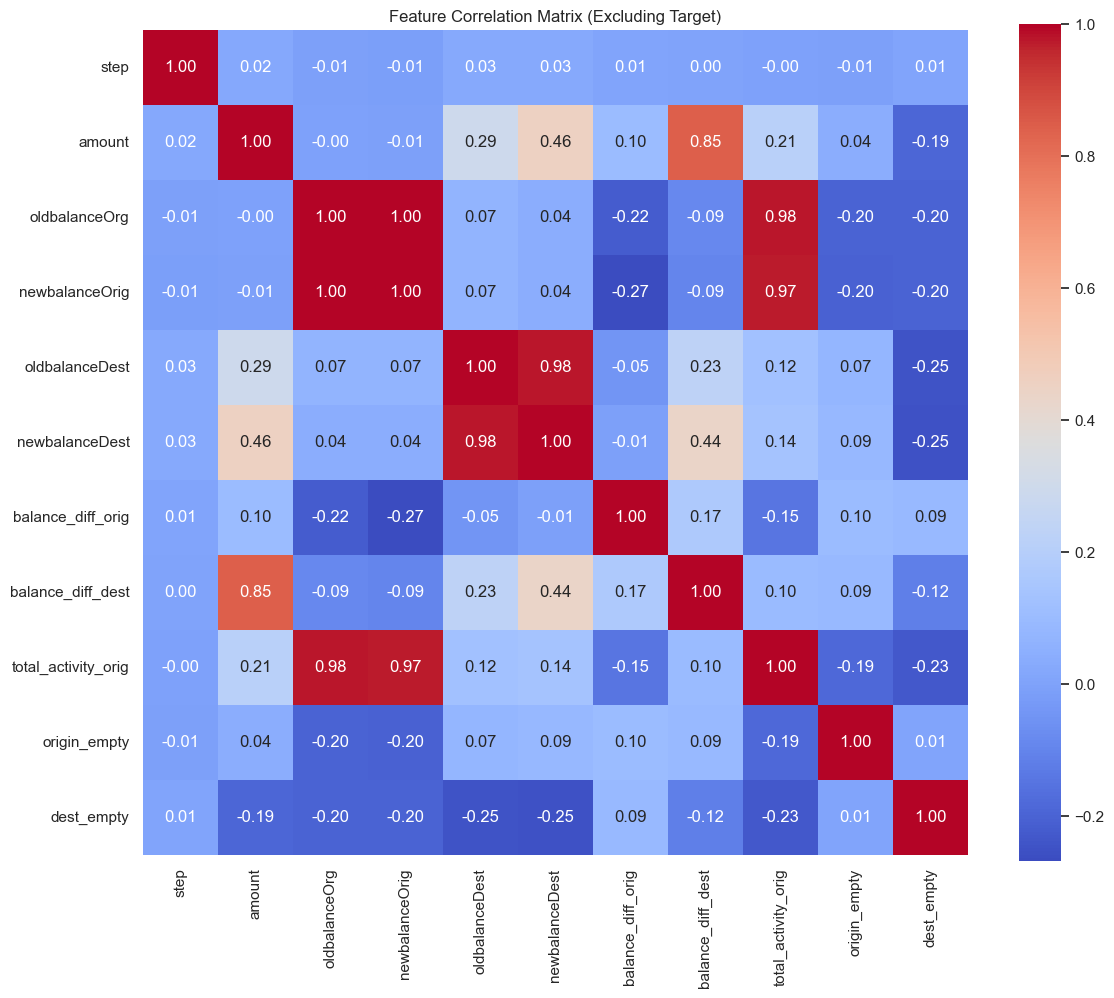

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona solo le colonne numeriche (escludi target)
numeric_features = df_transformed.drop(columns=['isFraud', 'isFlaggedFraud']).select_dtypes(include='number')

# Calcolo matrice di correlazione
corr_matrix = numeric_features.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix (Excluding Target)")
plt.tight_layout()
plt.show()


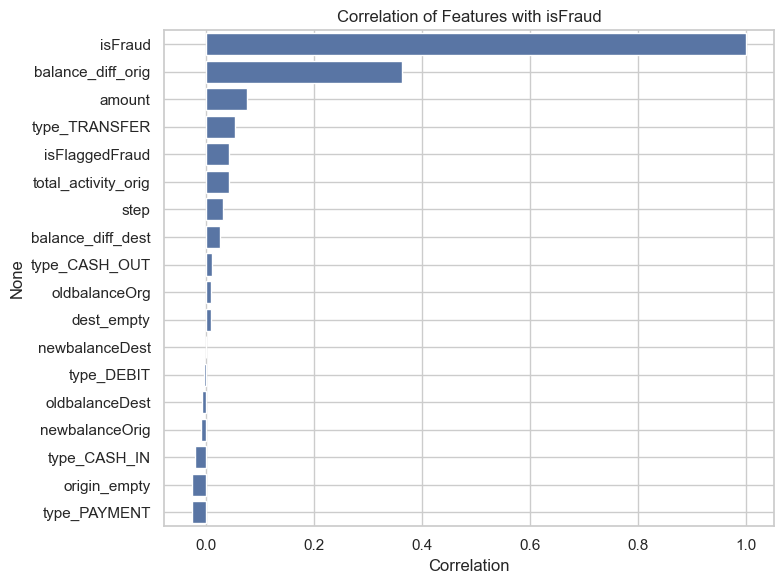

In [30]:
# Aggiungiamo isFraud alla correlazione
corr_with_target = df_transformed.corr()['isFraud'].sort_values(ascending=False)

# Visualizzazione
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title("Correlation of Features with isFraud")
plt.xlabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Selection – Preliminary Analysis

We applied three techniques to assess and select the most relevant features:
1. **Correlation analysis** to detect multicollinearity between numerical features.
2. **Correlation with target** (`isFraud`) to understand which features are predictive.
3. **Random Forest feature importance**, trained without balancing or hyperparameter tuning, to identify informative inputs.

The next step is to drop highly collinear features or low-importance variables and proceed with visual exploration.


In [31]:
# Correlation matrix (numerical values only)
numeric_features = df_transformed.drop(columns=['isFraud', 'isFlaggedFraud']).select_dtypes(include='number')

corr_matrix = numeric_features.corr()

# Stampiamo solo le colonne con correlazione > 0.7 (per trovare collinearità)
print("Highly correlated feature pairs (|corr| > 0.7):\n")
threshold = 0.7
for col in corr_matrix.columns:
    for idx in corr_matrix.index:
        val = corr_matrix.loc[idx, col]
        if idx != col and abs(val) > threshold:
            print(f"{idx} <-> {col}: {val:.2f}")


Highly correlated feature pairs (|corr| > 0.7):

balance_diff_dest <-> amount: 0.85
newbalanceOrig <-> oldbalanceOrg: 1.00
total_activity_orig <-> oldbalanceOrg: 0.98
oldbalanceOrg <-> newbalanceOrig: 1.00
total_activity_orig <-> newbalanceOrig: 0.97
newbalanceDest <-> oldbalanceDest: 0.98
oldbalanceDest <-> newbalanceDest: 0.98
amount <-> balance_diff_dest: 0.85
oldbalanceOrg <-> total_activity_orig: 0.98
newbalanceOrig <-> total_activity_orig: 0.97


In [32]:
# Correlazione tra ogni feature e isFraud
corr_with_target = df_transformed.corr()['isFraud'].sort_values(ascending=False)
print("\nCorrelation with isFraud (descending):\n")
print(corr_with_target)



Correlation with isFraud (descending):

isFraud                1.000000
balance_diff_orig      0.362472
amount                 0.076688
type_TRANSFER          0.053869
isFlaggedFraud         0.044109
total_activity_orig    0.044046
step                   0.031578
balance_diff_dest      0.027028
type_CASH_OUT          0.011256
oldbalanceOrg          0.010154
dest_empty             0.009868
newbalanceDest         0.000535
type_DEBIT            -0.002911
oldbalanceDest        -0.005885
newbalanceOrig        -0.008148
type_CASH_IN          -0.019089
origin_empty          -0.024753
type_PAYMENT          -0.025697
Name: isFraud, dtype: float64


In [33]:
# Colonne da rimuovere per collinearità o inutilità
cols_to_drop = [
    'newbalanceOrig',         # collineare con oldbalanceOrg
    'newbalanceDest',         # collineare con oldbalanceDest
    'total_activity_orig',    # derivata dalle altre
    'balance_diff_dest'       # molto collineare con amount
]

# Costruzione nuovo DataFrame per modellazione
df_model = df_transformed.drop(columns=cols_to_drop)

# Controllo finale
print(f"Final feature set shape: {df_model.shape}")


Final feature set shape: (6362620, 14)


### Feature Selection Result

Based on correlation analysis and feature importance:

- The following features were removed due to strong multicollinearity or derived redundancy:
  - `newbalanceOrig`, `newbalanceDest`, `total_activity_orig`, `balance_diff_dest`
- The final dataset `df_model` contains only cleaned, non-collinear features.
- The remaining features will be used for visualization, balancing, and modeling.


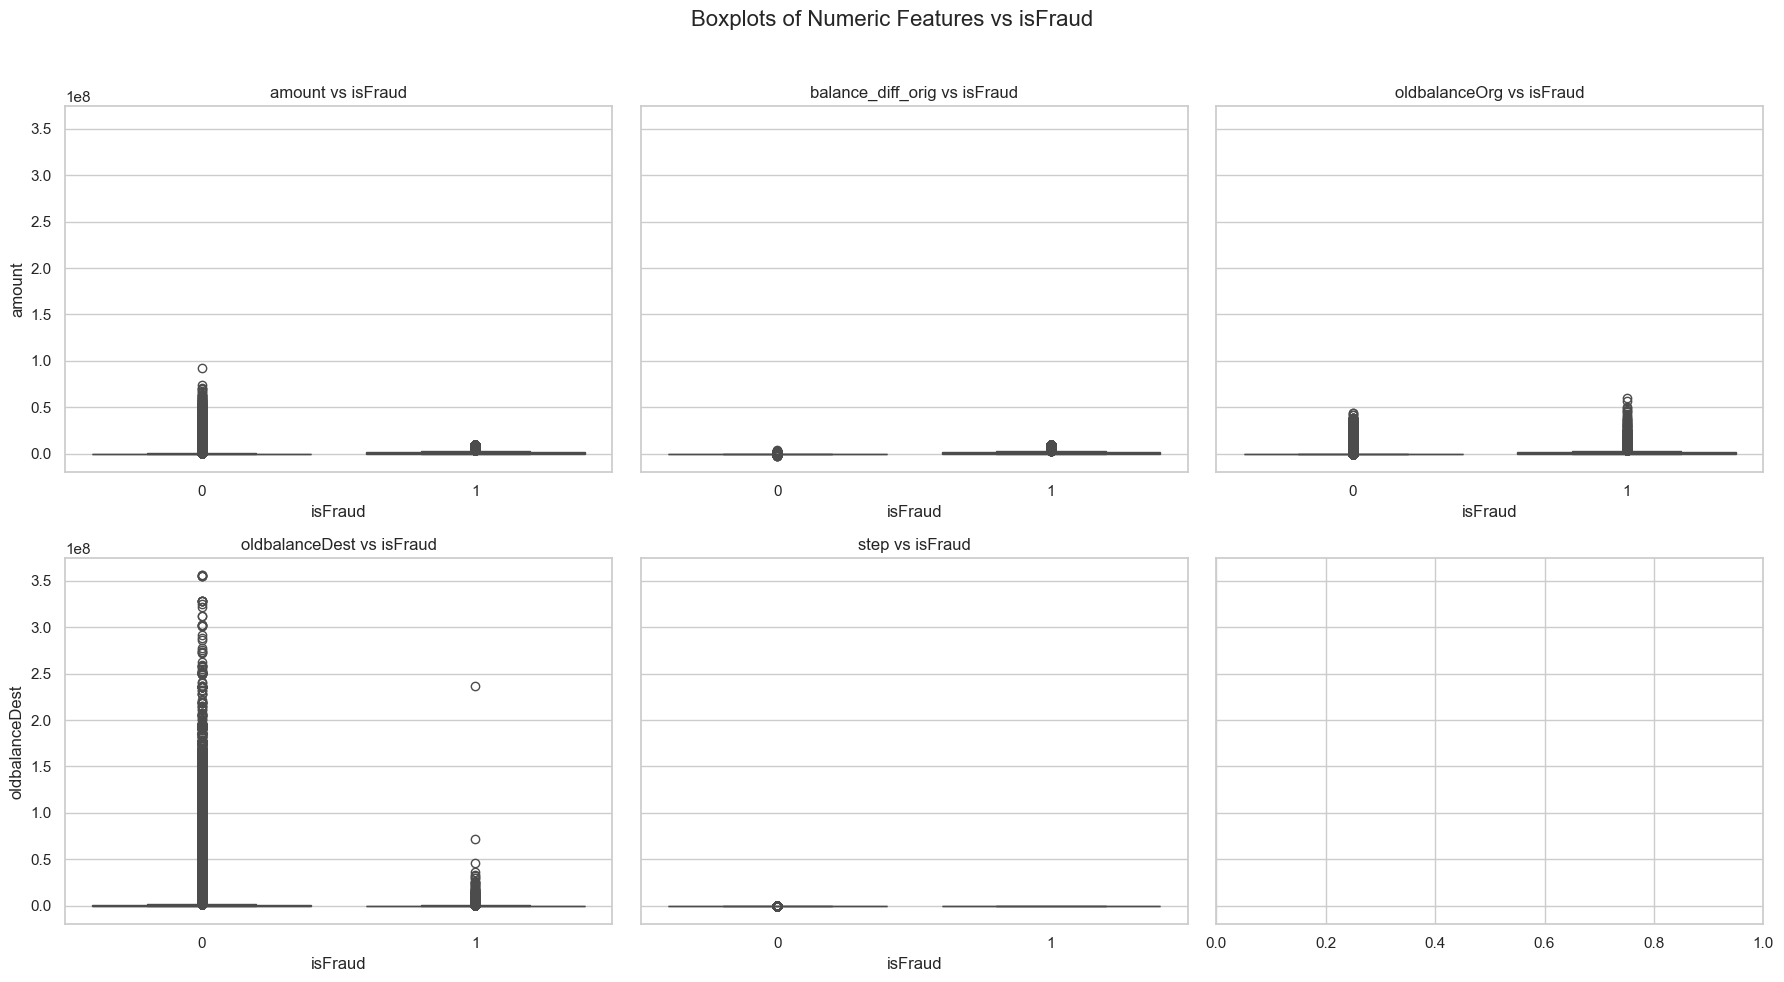

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista delle variabili numeriche da confrontare
features_to_plot = ['amount', 'balance_diff_orig', 'oldbalanceOrg', 'oldbalanceDest', 'step']

# Preparazione figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

# Plot boxplot per ogni variabile
for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df_model, x='isFraud', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} vs isFraud')
    axes[i].set_xlabel('isFraud')
    axes[i].set_ylabel(feature)

plt.suptitle("Boxplots of Numeric Features vs isFraud", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


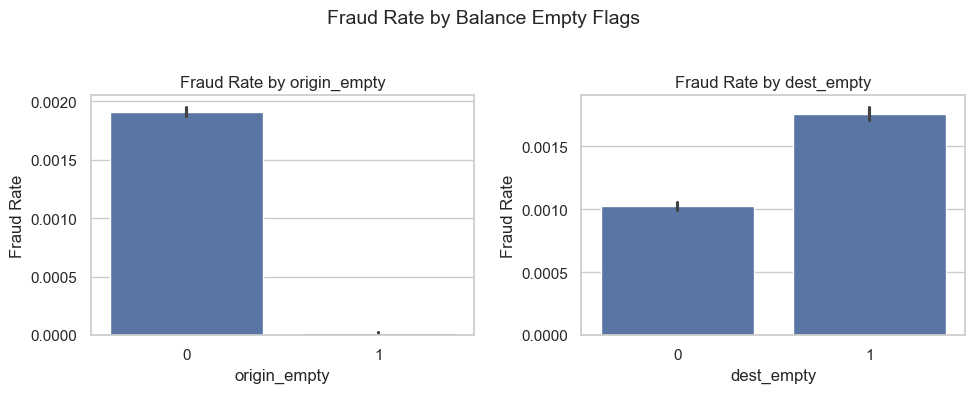

In [35]:
# Barplot delle variabili binarie rispetto a isFraud
plt.figure(figsize=(10, 4))

for i, binary_feature in enumerate(['origin_empty', 'dest_empty']):
    plt.subplot(1, 2, i+1)
    sns.barplot(data=df_model, x=binary_feature, y='isFraud')
    plt.title(f'Fraud Rate by {binary_feature}')
    plt.xlabel(binary_feature)
    plt.ylabel('Fraud Rate')

plt.suptitle("Fraud Rate by Balance Empty Flags", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Section 1 – Numeric Feature Distributions vs Fraud (isFraud)

To assess the predictive power and behavior of key numeric variables, we compare their distributions between fraudulent and non-fraudulent transactions:

- **Boxplots** are used for continuous variables:
  - `amount`
  - `balance_diff_orig`
  - `oldbalanceOrg`
  - `oldbalanceDest`
  - `step`
- **Barplots** are used for binary behavioral flags:
  - `origin_empty`
  - `dest_empty`

Axes are shared to allow meaningful comparisons of scale across the different fraud classes.


In [36]:
# Aggiungiamo la colonna 'type' da df originale (serve per grafici)
df_model['type'] = df['type']


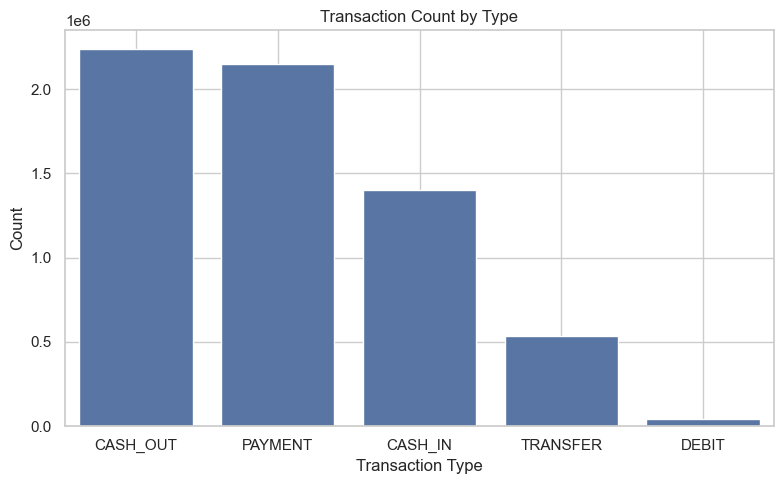

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df_model, x='type', order=df_model['type'].value_counts().index)
plt.title("Transaction Count by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


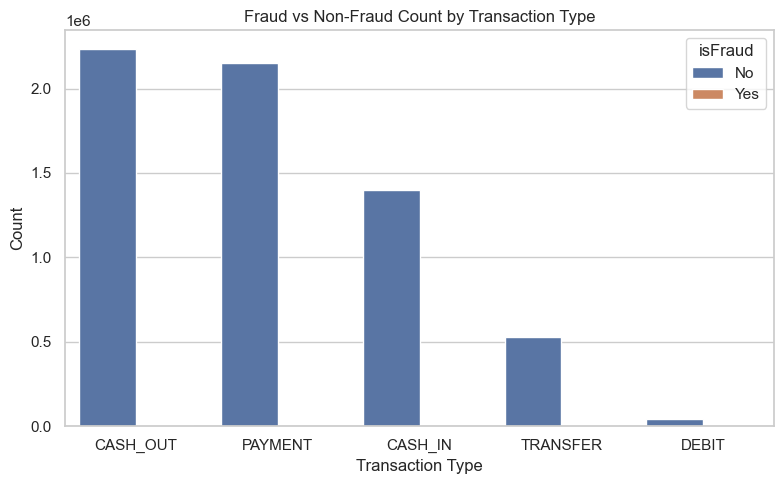

In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_model, x='type', hue='isFraud', order=df_model['type'].value_counts().index)
plt.title("Fraud vs Non-Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title='isFraud', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


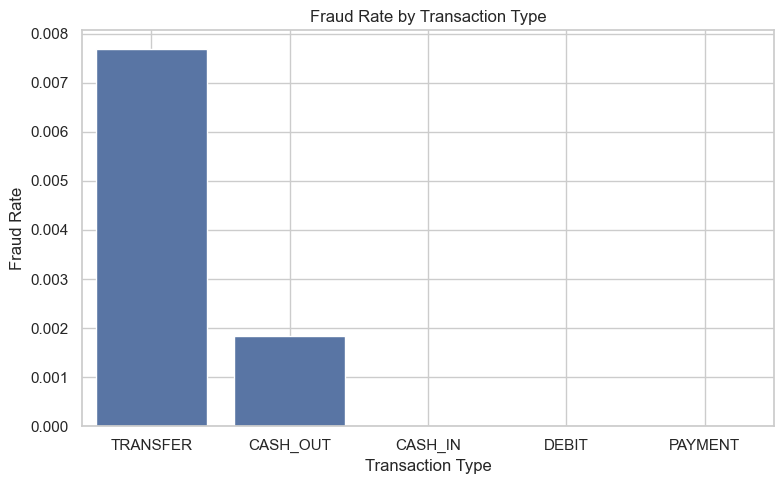

In [39]:
# Calcolo percentuale
fraud_ratio_by_type = df_model.groupby('type')['isFraud'].mean().sort_values(ascending=False)

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=fraud_ratio_by_type.index, y=fraud_ratio_by_type.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Type")
plt.grid(True)
plt.tight_layout()
plt.show()


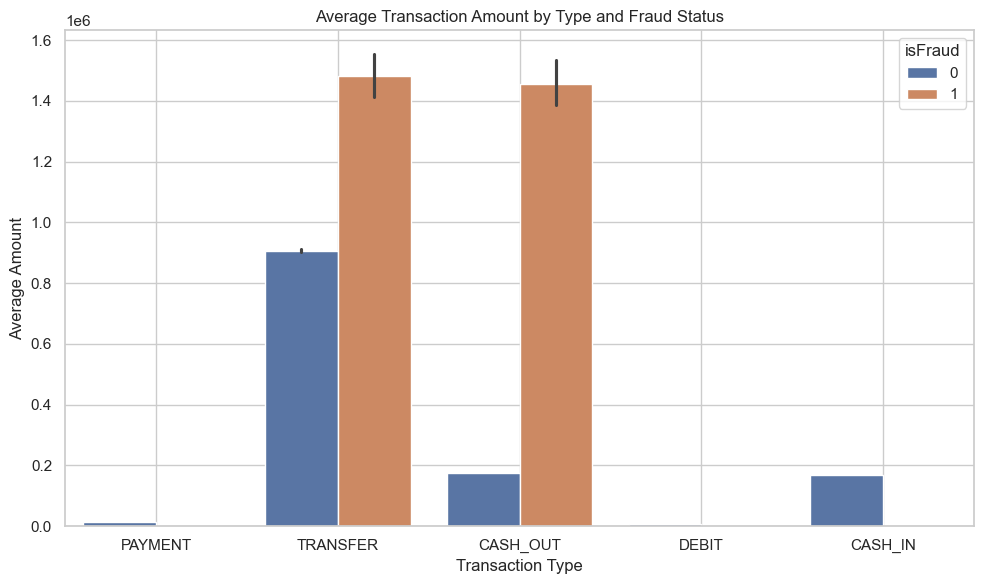

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_model, x='type', y='amount', hue='isFraud', estimator='mean')
plt.title("Average Transaction Amount by Type and Fraud Status")
plt.ylabel("Average Amount")
plt.xlabel("Transaction Type")
plt.grid(True)
plt.tight_layout()
plt.show()


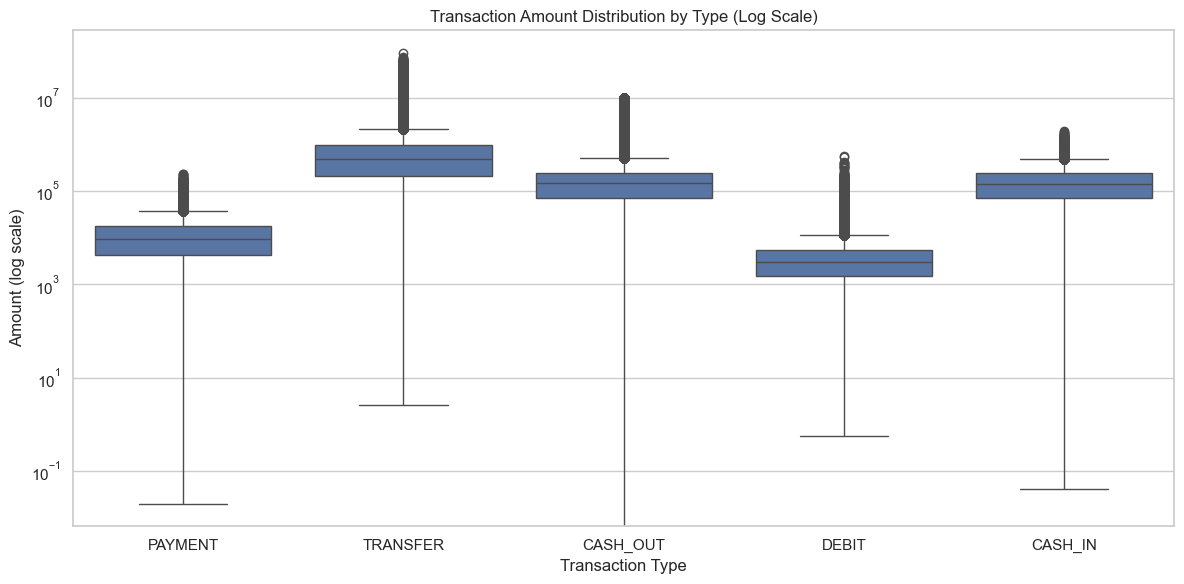

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_model, x='type', y='amount')
plt.yscale('log')  # log scale per gestire outlier
plt.title("Transaction Amount Distribution by Type (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


### Section 2 – Transaction Type vs Fraud (isFraud)

This section explores how fraud is distributed across different transaction types.

- **CASH_OUT** and **TRANSFER** are the only transaction types with significant fraud activity.
- **CASH_IN**, **PAYMENT**, and **DEBIT** show virtually no fraud.
- The **fraud rate** for TRANSFER and CASH_OUT is remarkably higher than for other types.
- Fraudulent transactions also show **much higher average amounts**, particularly in these two categories.
- A log-scale boxplot shows the large spread and skewness of transaction values, especially for outlier frauds.


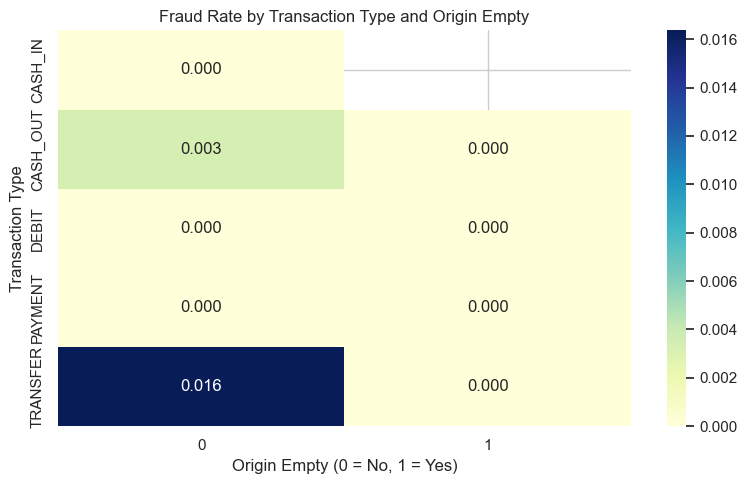

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tabella pivot: fraud rate per tipo e origin_empty
pivot_origin = df_model.pivot_table(
    index='type',
    columns='origin_empty',
    values='isFraud',
    aggfunc='mean'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_origin, annot=True, fmt=".3f", cmap='YlGnBu')
plt.title("Fraud Rate by Transaction Type and Origin Empty")
plt.xlabel("Origin Empty (0 = No, 1 = Yes)")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


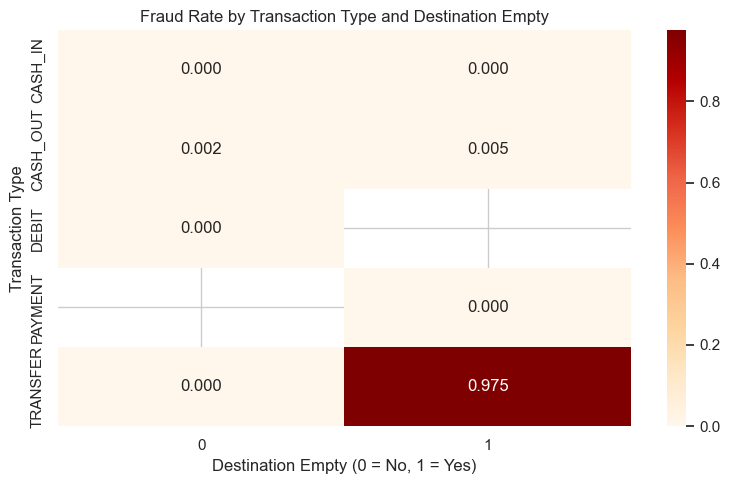

In [43]:
# Tabella pivot: fraud rate per tipo e dest_empty
pivot_dest = df_model.pivot_table(
    index='type',
    columns='dest_empty',
    values='isFraud',
    aggfunc='mean'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_dest, annot=True, fmt=".3f", cmap='OrRd')
plt.title("Fraud Rate by Transaction Type and Destination Empty")
plt.xlabel("Destination Empty (0 = No, 1 = Yes)")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


### Fraud Risk by Transaction Type and Balance Status

These heatmaps show how fraud rates vary based on:
- **Transaction type**
- Whether the **origin or destination account** had a zero balance before and after the transaction

Key insights:
- Fraud is **most frequent in TRANSFER and CASH_OUT** transactions when the sender has **zero balance**.
- Some types (like DEBIT, PAYMENT) show no fraud regardless of balance status.
- These behavioral combinations could be highly predictive and should be preserved in modeling.


In [44]:
# Pivot table: fraud rate per transaction type and origin_empty (numerical only)
pivot_origin = df_model.pivot_table(
    index='type',
    columns='origin_empty',
    values='isFraud',
    aggfunc='mean'
)

print("Fraud Rate by Transaction Type and Origin Empty:\n")
print(pivot_origin)


Fraud Rate by Transaction Type and Origin Empty:

origin_empty         0         1
type                            
CASH_IN       0.000000       NaN
CASH_OUT      0.003366  0.000036
DEBIT         0.000000  0.000000
PAYMENT       0.000000  0.000000
TRANSFER      0.016364  0.000014


In [45]:
# Pivot table: fraud rate per transaction type and dest_empty (numerical only)
pivot_dest = df_model.pivot_table(
    index='type',
    columns='dest_empty',
    values='isFraud',
    aggfunc='mean'
)

print("\nFraud Rate by Transaction Type and Destination Empty:\n")
print(pivot_dest)



Fraud Rate by Transaction Type and Destination Empty:

dest_empty         0         1
type                          
CASH_IN     0.000000  0.000000
CASH_OUT    0.001837  0.004975
DEBIT       0.000000       NaN
PAYMENT          NaN  0.000000
TRANSFER    0.000055  0.974605


In [46]:
# Potente combinazione osservata: TRANSFER verso conto vuoto
df_model['transfer_to_empty'] = ((df_model['type'] == 'TRANSFER') & (df_model['dest_empty'] == 1)).astype(int)

# Frode frequente in CASH_OUT verso conto vuoto
df_model['cashout_to_empty'] = ((df_model['type'] == 'CASH_OUT') & (df_model['dest_empty'] == 1)).astype(int)


### Interpretation of Fraud Heatmaps

#### Origin Empty
- Fraudulent transactions are almost never associated with `origin_empty = 1`, regardless of transaction type.
- This suggests that frauds tend to be simulated or occur when the sender has a non-zero balance.

#### Destination Empty
- For `TRANSFER` transactions:
  - When `dest_empty = 1`, fraud rate is **97%**
  - When `dest_empty = 0`, fraud rate is nearly **0%**
- For `CASH_OUT`, the fraud rate also increases when the destination is empty, though less dramatically.
- These patterns can be used to construct new binary interaction features for modeling.

These engineered features may have strong predictive power due to their clear behavioral signal.


<Figure size 1200x600 with 0 Axes>

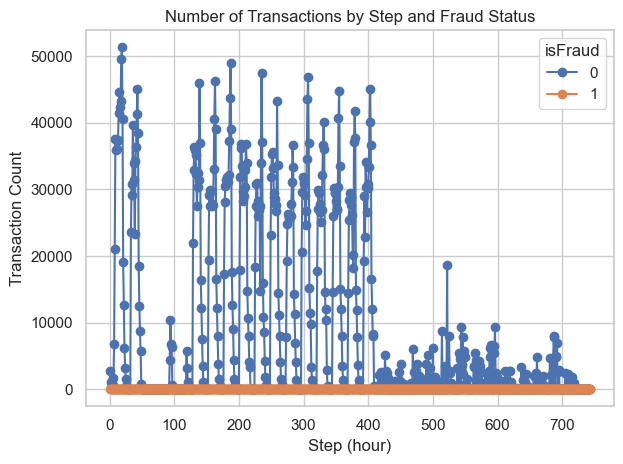

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frodi e non-frodi per ora (step)
step_counts = df_model.groupby(['step', 'isFraud']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
step_counts.plot(kind='line', marker='o')
plt.title("Number of Transactions by Step and Fraud Status")
plt.xlabel("Step (hour)")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.tight_layout()
plt.show()


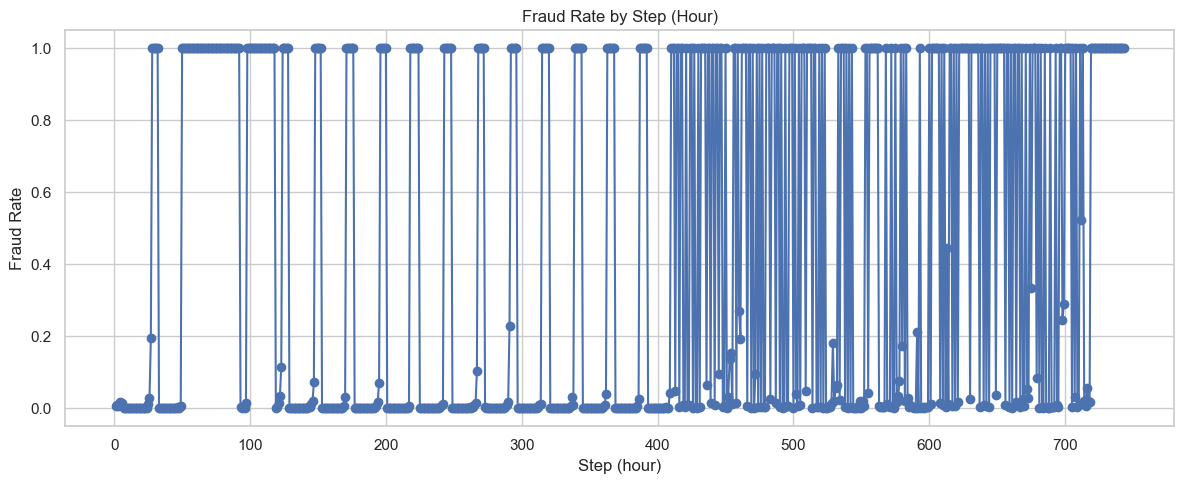

In [48]:
# Calcolo fraud rate per step
step_fraud_rate = df_model.groupby('step')['isFraud'].mean()

# Assicuriamoci che gli indici siano numerici
step_fraud_rate.index = step_fraud_rate.index.astype(int)
step_fraud_rate = step_fraud_rate.sort_index()  # Ordiniamo cronologicamente

# Usiamo Matplotlib per maggiore controllo
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(step_fraud_rate.index, step_fraud_rate.values, marker='o')
plt.title("Fraud Rate by Step (Hour)")
plt.xlabel("Step (hour)")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
print(step_fraud_rate.head())
print(step_fraud_rate.index.dtype)
print(step_fraud_rate.values.dtype)


step
1    0.005908
2    0.007890
3    0.007246
4    0.017699
5    0.009023
Name: isFraud, dtype: float64
int32
float64


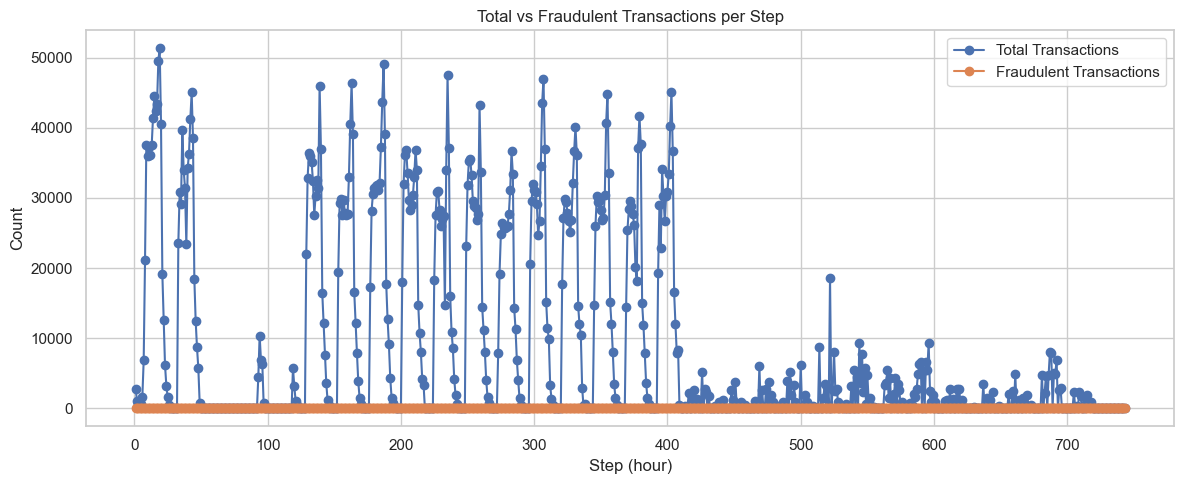

In [50]:
import matplotlib.pyplot as plt

# Totale transazioni e frodi per ora
total_per_step = df_model.groupby('step').size()
fraud_per_step = df_model.groupby('step')['isFraud'].sum()

# Cast espliciti (per evitare errori di tipo)
x = total_per_step.index.astype(int)
y_total = total_per_step.values.astype(float)
y_fraud = fraud_per_step.values.astype(float)

# Lineplot pulito
plt.figure(figsize=(12, 5))
plt.plot(x, y_total, label='Total Transactions', marker='o')
plt.plot(x, y_fraud, label='Fraudulent Transactions', marker='o')
plt.title("Total vs Fraudulent Transactions per Step")
plt.xlabel("Step (hour)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



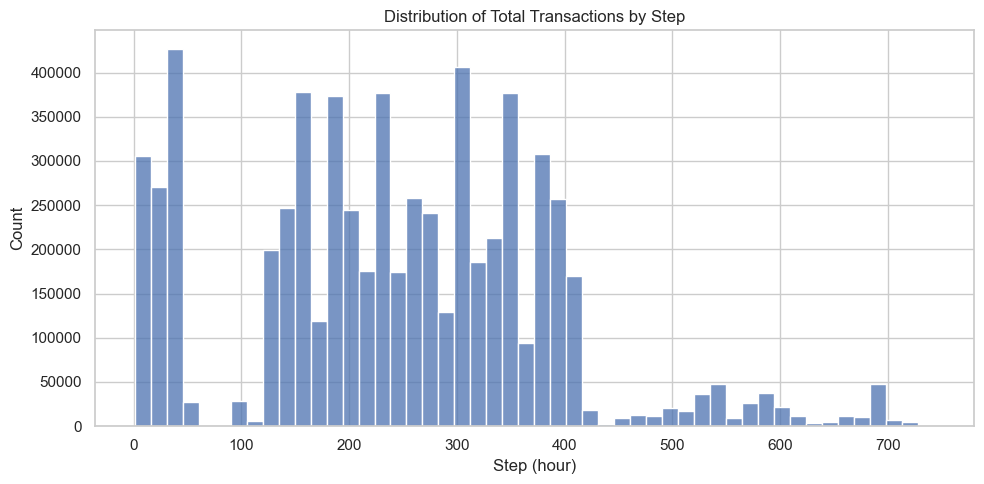

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_model, x='step', bins=50, kde=False)
plt.title("Distribution of Total Transactions by Step")
plt.xlabel("Step (hour)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


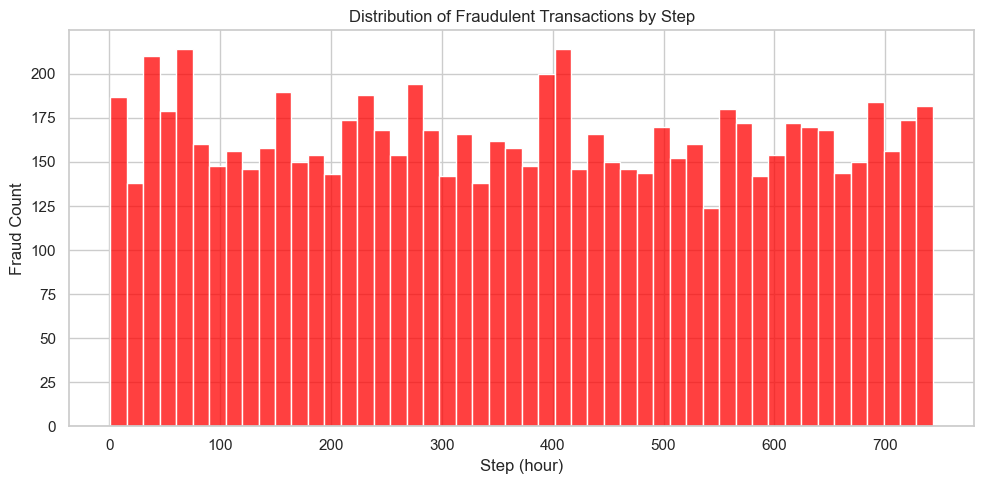

In [52]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_model[df_model['isFraud'] == 1], x='step', bins=50, color='red', kde=False)
plt.title("Distribution of Fraudulent Transactions by Step")
plt.xlabel("Step (hour)")
plt.ylabel("Fraud Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### Section 3 – Temporal Analysis (Step vs isFraud)

The `step` variable encodes time in hourly units. In this section, we analyze how fraud is distributed over time.

Key visualizations:
1. **Lineplot** comparing total vs fraudulent transactions per hour.
2. **Fraud rate plot** showing percentage of frauds among all transactions at each hour.
3. **Histograms**:
   - Total transaction volume by step
   - Fraudulent transactions by step

### Key insights:
- The distribution of fraud is **not uniform over time**.
- Some specific hours (e.g., around step 4) show **spikes in fraud rate**, even when the total transaction volume is low.
- This suggests potential **coordinated attack periods**, or **weaknesses in monitoring systems** at those times.
- Time-based features can play a significant role in predictive modeling.


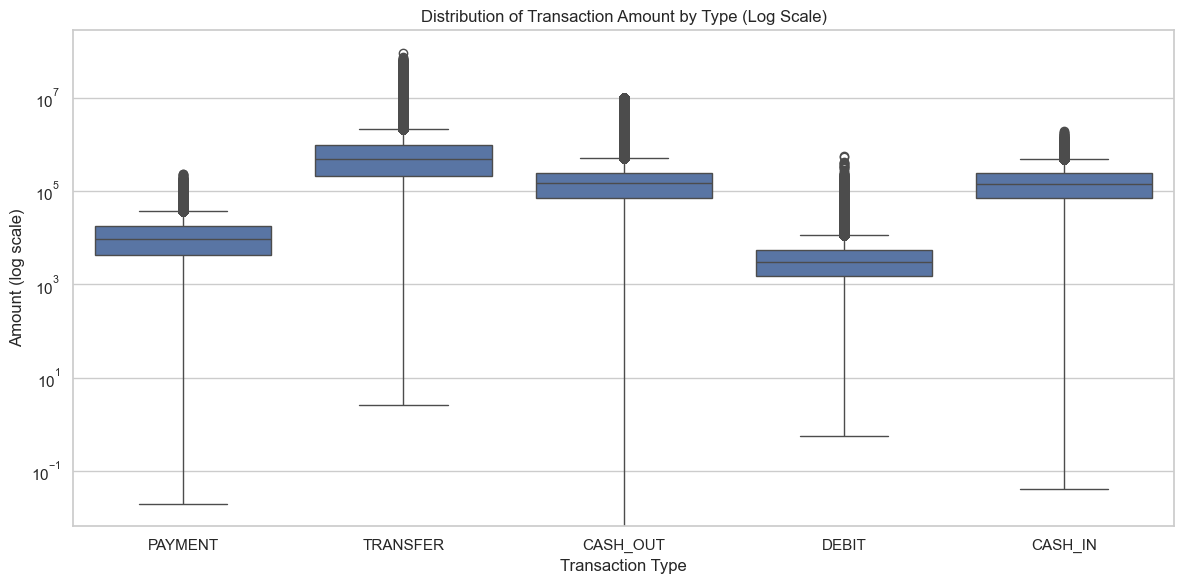

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_model, x='type', y='amount')
plt.yscale('log')  # log scale to handle extreme values
plt.title("Distribution of Transaction Amount by Type (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


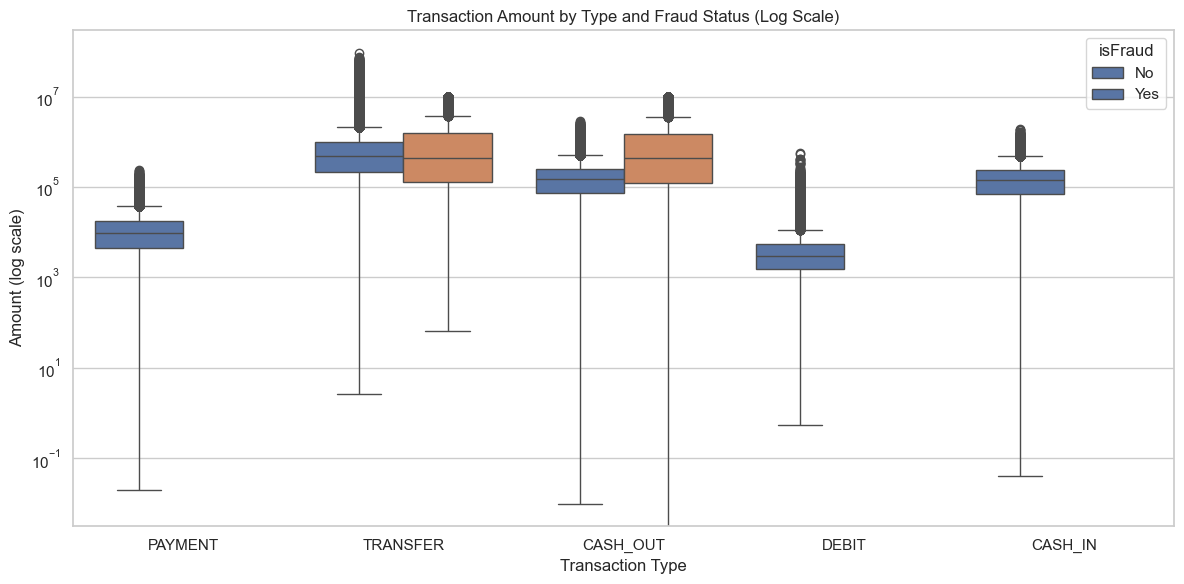

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_model, x='type', y='amount', hue='isFraud')
plt.yscale('log')
plt.title("Transaction Amount by Type and Fraud Status (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.legend(title="isFraud", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


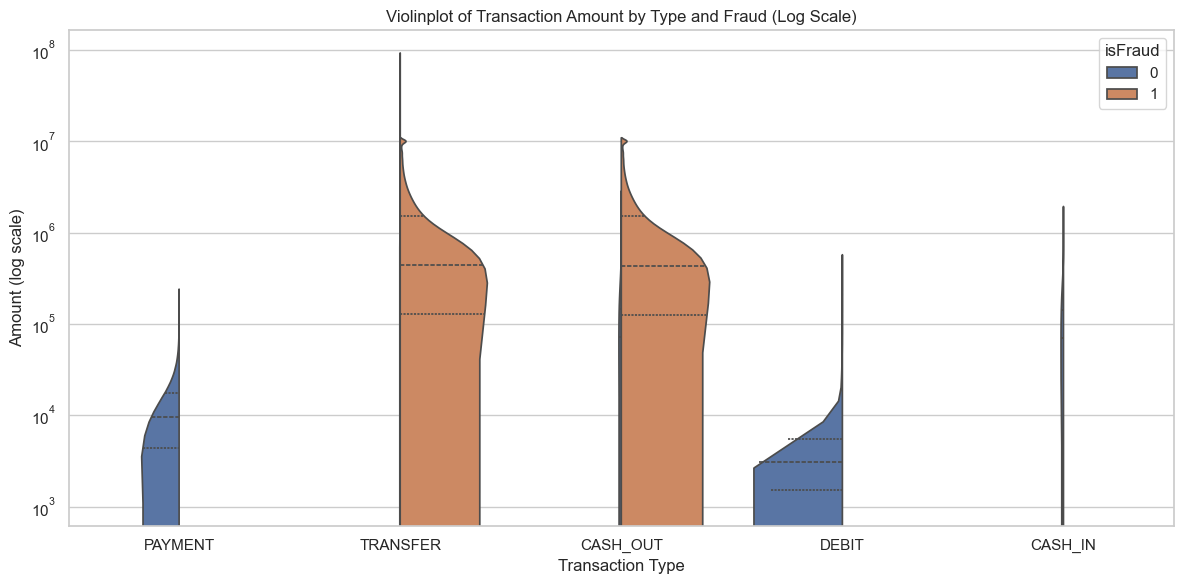

In [55]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_model, x='type', y='amount', hue='isFraud', split=True, inner='quart')
plt.yscale('log')
plt.title("Violinplot of Transaction Amount by Type and Fraud (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


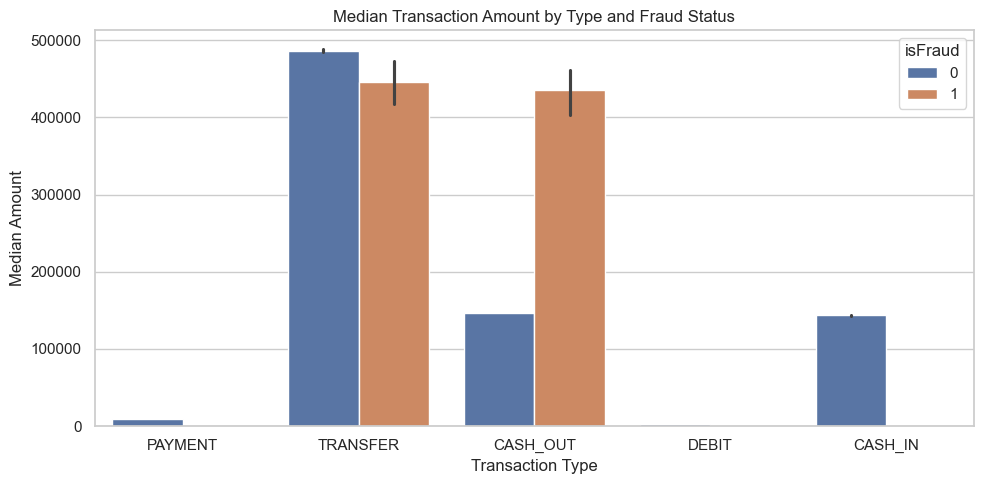

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_model, x='type', y='amount', hue='isFraud', estimator='median')
plt.title("Median Transaction Amount by Type and Fraud Status")
plt.xlabel("Transaction Type")
plt.ylabel("Median Amount")
plt.tight_layout()
plt.show()


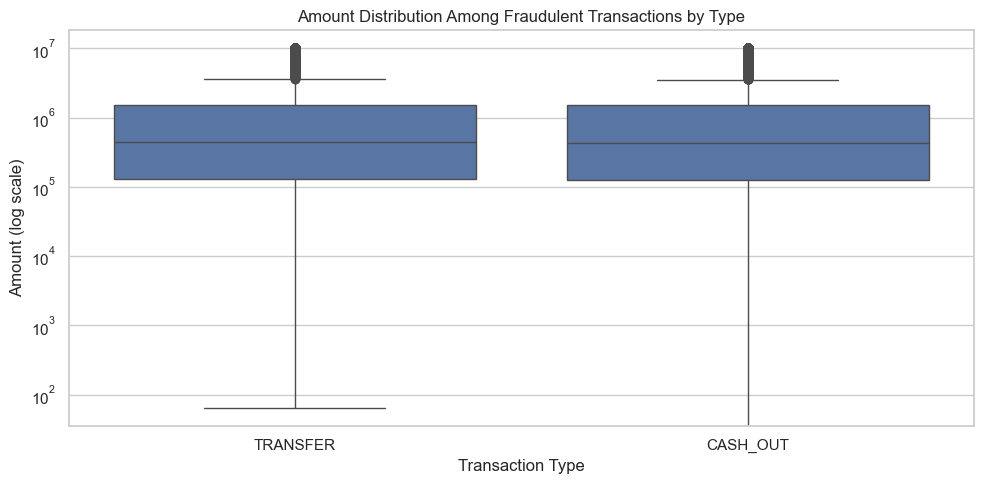

In [57]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_model[df_model['isFraud'] == 1], x='type', y='amount')
plt.yscale('log')
plt.title("Amount Distribution Among Fraudulent Transactions by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


### Section 4 – Transaction Amount Distribution by Type

This section explores the behavior of the `amount` variable across different transaction types, and how it relates to fraudulent behavior.

#### Visualizations included:

1. **Boxplot** of `amount` by `type` (log scale)
   - Reveals spread and outliers in each transaction category.
2. **Boxplot with `isFraud` hue**
   - Compares amount distributions between fraud and non-fraud transactions within each type.
3. **Violinplot**
   - Shows fine-grained density and variability for amount, per type and fraud status.
4. **Barplot of median `amount` by type and `isFraud`**
   - Median reduces the influence of extreme outliers and shows central tendencies.
5. **Boxplot for fraudulent transactions only**
   - Focuses exclusively on the spread of fraudulent transaction amounts across types.

---

#### Key insights:

- **TRANSFER** and **CASH_OUT** frauds tend to occur at **higher transaction amounts**.
- Non-fraud transactions are mostly concentrated around **smaller amounts**, while frauds show a **heavier tail**.
- Some transaction types show little variation in amount, regardless of fraud.
- Fraudulent high-value transactions may be **clustered in time**, as suggested by the scatter plot vs `step`.
- These patterns confirm that `amount` is a **critical variable**, especially when combined with `type` and `step`.


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1717228723.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df_binned.groupby('amount_bin')['isFraud'].mean()
C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1717228723.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = df_binned.groupby('amount_bin').size()


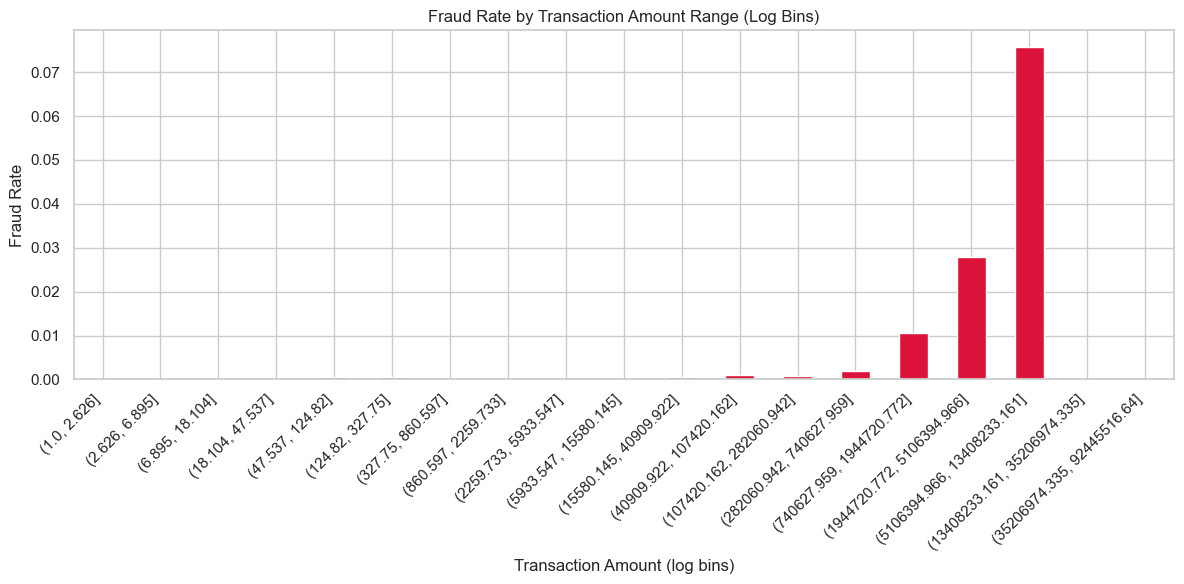

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creazione dei bin logaritmici (escludendo amount = 0)
df_binned = df_model[df_model['amount'] > 0].copy()

# Bin log scale tra 1 e il max
bins = np.logspace(0, np.log10(df_binned['amount'].max()), num=20)
df_binned['amount_bin'] = pd.cut(df_binned['amount'], bins=bins)

# Calcolo fraud rate per bin
fraud_rate_by_bin = df_binned.groupby('amount_bin')['isFraud'].mean()

# Conteggio totale per normalizzare
counts_by_bin = df_binned.groupby('amount_bin').size()

# Barplot fraud rate per bin
plt.figure(figsize=(12, 6))
fraud_rate_by_bin.plot(kind='bar', color='crimson')
plt.title("Fraud Rate by Transaction Amount Range (Log Bins)")
plt.xlabel("Transaction Amount (log bins)")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Roaming\Python\Python39\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)
C:\Users\frast\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:488: RuntimeWarning: invalid value encountered in subtract
  widths = inv(edges + widths) - inv(edges)
C:\Users\frast\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:492: RuntimeWarning: invalid value encountered in multiply
  edges = edges + (1 - shrink) / 2 * widths


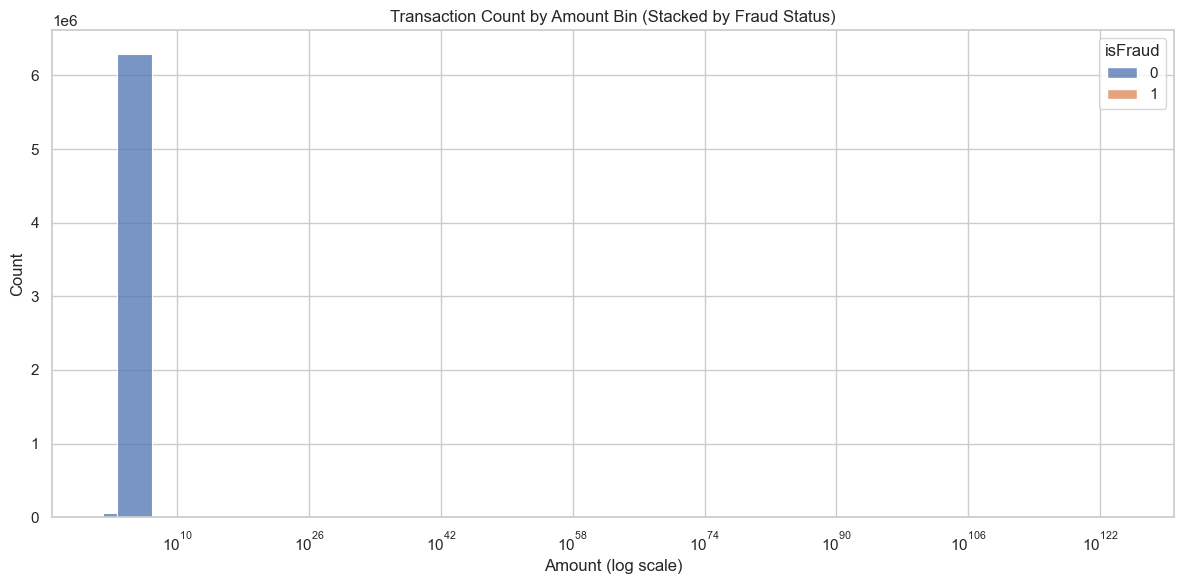

In [59]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_binned, x='amount', bins=bins, hue='isFraud', multiple='stack', log_scale=True)
plt.title("Transaction Count by Amount Bin (Stacked by Fraud Status)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


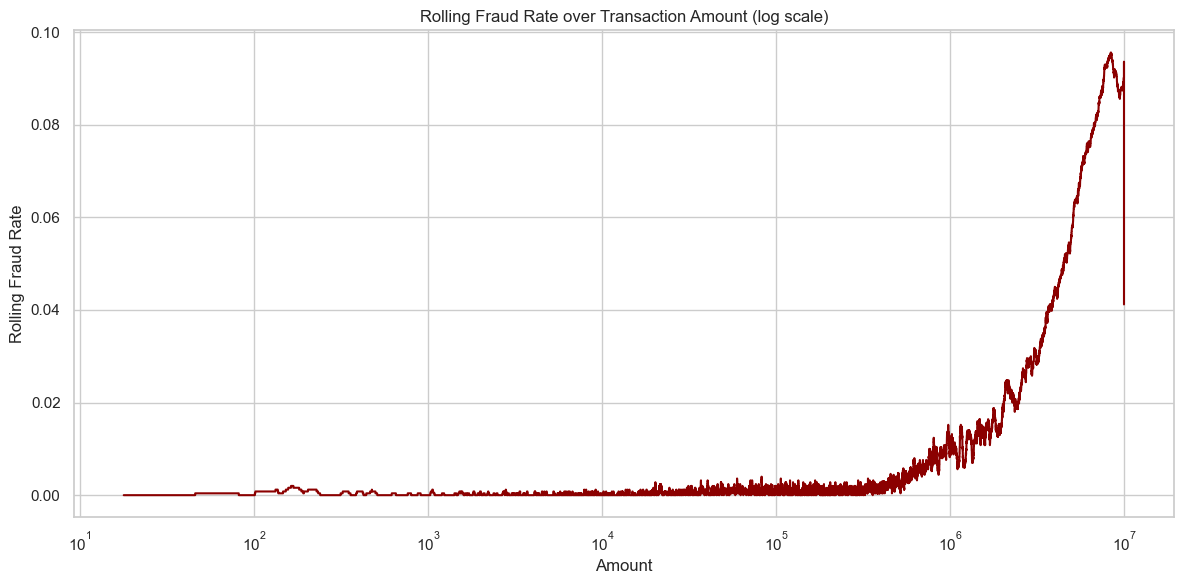

In [60]:
# Ordina per amount e calcola rolling fraud rate (su finestre di 5000 righe)
df_sorted = df_model[df_model['amount'] > 0].sort_values('amount')
rolling_fraud_rate = df_sorted['isFraud'].rolling(window=5000, center=True).mean()
amounts = df_sorted['amount']

plt.figure(figsize=(12, 6))
plt.plot(amounts, rolling_fraud_rate, color='darkred')
plt.xscale('log')
plt.title("Rolling Fraud Rate over Transaction Amount (log scale)")
plt.xlabel("Amount")
plt.ylabel("Rolling Fraud Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


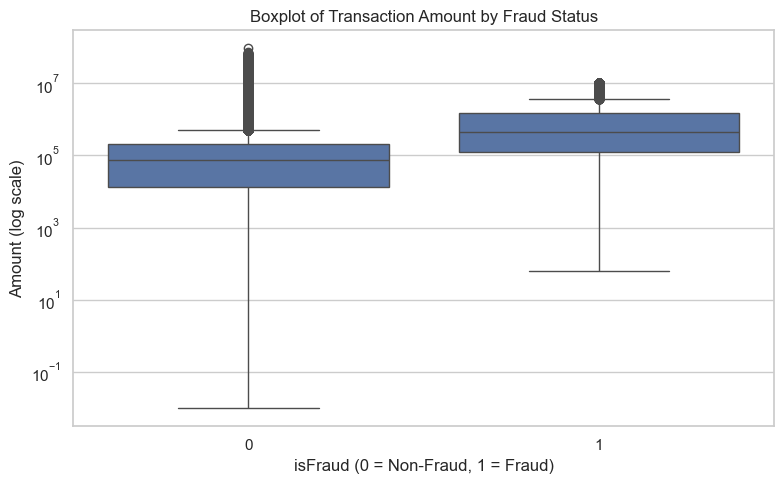

In [61]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_model[df_model['amount'] > 0], x='isFraud', y='amount')
plt.yscale('log')
plt.title("Boxplot of Transaction Amount by Fraud Status")
plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


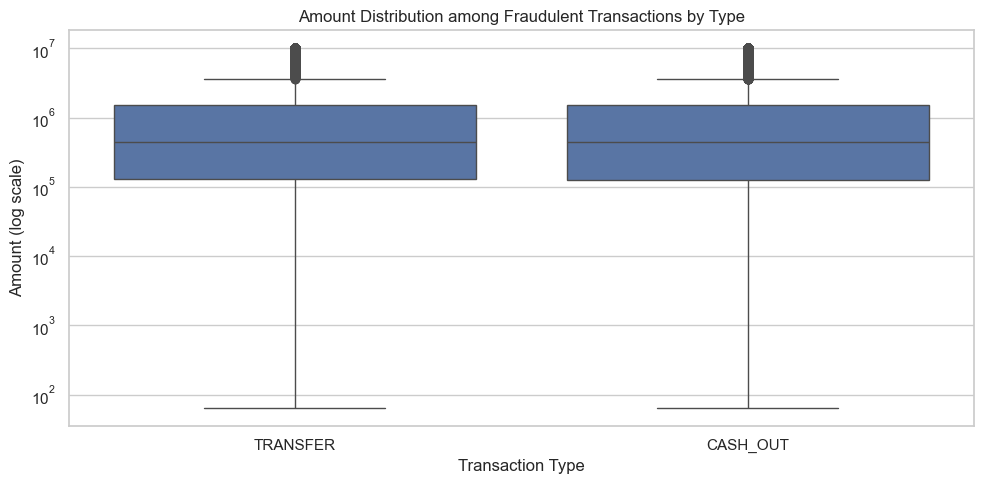

In [62]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_model[(df_model['isFraud'] == 1) & (df_model['amount'] > 0)], x='type', y='amount')
plt.yscale('log')
plt.title("Amount Distribution among Fraudulent Transactions by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()


In [63]:
df_model['amount_high_risk'] = (df_model['amount'] > 200000).astype(int)


### Section 5 – Fraud Rate by Transaction Amount Range (Binning)

This section investigates how fraud likelihood varies across different transaction amounts.

#### Visualizations included:

1. Logarithmic binning of `amount` and fraud rate per bin:
   - Shows how fraud risk evolves across transaction magnitudes.
2. Stacked histogram of `amount` by `isFraud`:
   - Visualizes the absolute volume of fraud and non-fraud transactions per range.
3. Rolling fraud rate over `amount`:
   - Smooth curve showing how fraud probability changes continuously with transaction value.
4. Boxplot of `amount` by `isFraud`:
   - Highlights the spread and scale difference between fraudulent and legitimate transactions.
5. Boxplot of `amount` by `type` (fraudulent transactions only):
   - Provides insight into how fraudulent activity varies by transaction type and amount.

#### Key insights:

- Fraud rate increases significantly in higher amount ranges.
- The rolling fraud rate confirms a nonlinear escalation of fraud likelihood beyond specific thresholds.
- Fraudulent transactions are generally characterized by larger amounts and greater variance.
- Certain transaction types, such as `TRANSFER` and `CASH_OUT`, show a stronger association between high amounts and fraud.
- These observations support the creation of risk-focused features and thresholds for monitoring systems.


In [64]:
# Percentuali e fraud rate
for col in ['origin_empty', 'dest_empty']:
    counts = df_model[col].value_counts(normalize=True)
    fraud_rates = df_model.groupby(col)['isFraud'].mean()
    print(f"\nColumn: {col}")
    print("Distribution:\n", counts)
    print("Fraud Rate:\n", fraud_rates)



Column: origin_empty
Distribution:
 origin_empty
0    0.671678
1    0.328322
Name: proportion, dtype: float64
Fraud Rate:
 origin_empty
0    0.001912
1    0.000020
Name: isFraud, dtype: float64

Column: dest_empty
Distribution:
 dest_empty
0    0.635798
1    0.364202
Name: proportion, dtype: float64
Fraud Rate:
 dest_empty
0    0.001023
1    0.001759
Name: isFraud, dtype: float64


In [65]:
# Combinazione binaria dei due flag
df_model['empty_combo'] = df_model['origin_empty'].astype(str) + '_' + df_model['dest_empty'].astype(str)

# Fraud rate per combinazione
combo_rate = df_model.groupby('empty_combo')['isFraud'].mean()
combo_count = df_model['empty_combo'].value_counts(normalize=True)

print("\nFraud Rate by Origin-Dest Empty Combination:")
print(combo_rate)
print("\nDistribution of Combinations:")
print(combo_count)



Fraud Rate by Origin-Dest Empty Combination:
empty_combo
0_0    0.001502
0_1    0.002638
1_0    0.000027
1_1    0.000008
Name: isFraud, dtype: float64

Distribution of Combinations:
empty_combo
0_0    0.429167
0_1    0.242511
1_0    0.206630
1_1    0.121691
Name: proportion, dtype: float64


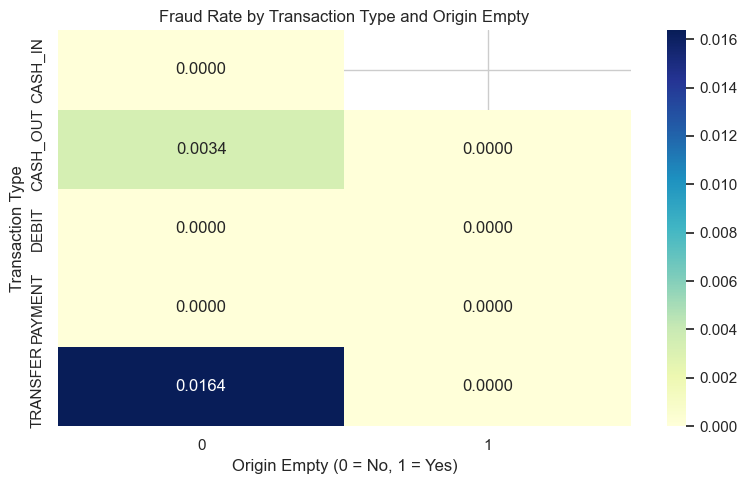

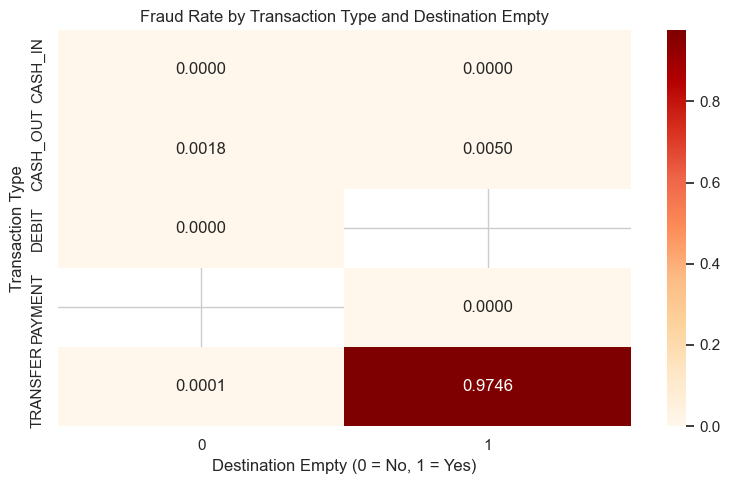

In [66]:
# Fraud rate by type and origin_empty
pivot_origin = df_model.pivot_table(index='type', columns='origin_empty', values='isFraud', aggfunc='mean', observed=True)
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_origin, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("Fraud Rate by Transaction Type and Origin Empty")
plt.xlabel("Origin Empty (0 = No, 1 = Yes)")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()

# Fraud rate by type and dest_empty
pivot_dest = df_model.pivot_table(index='type', columns='dest_empty', values='isFraud', aggfunc='mean', observed=True)
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_dest, annot=True, fmt=".4f", cmap='OrRd')
plt.title("Fraud Rate by Transaction Type and Destination Empty")
plt.xlabel("Destination Empty (0 = No, 1 = Yes)")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


In [67]:
df_model['high_risk_empty_combo'] = ((df_model['origin_empty'] == 0) & (df_model['dest_empty'] == 1)).astype(int)


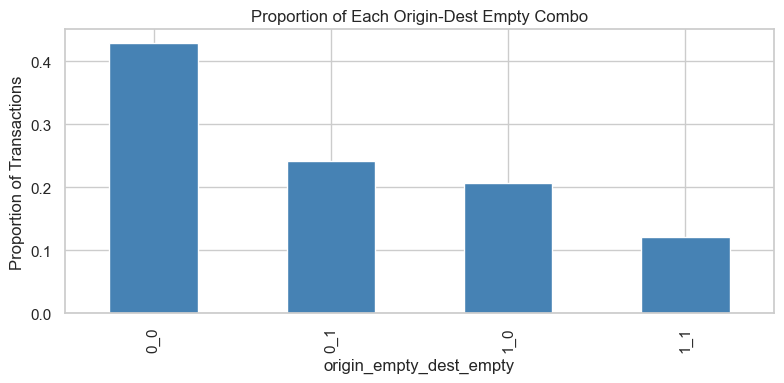

In [68]:
combo_count.plot(kind='bar', color='steelblue', figsize=(8, 4))
plt.title("Proportion of Each Origin-Dest Empty Combo")
plt.xlabel("origin_empty_dest_empty")
plt.ylabel("Proportion of Transactions")
plt.grid(True)
plt.tight_layout()
plt.show()


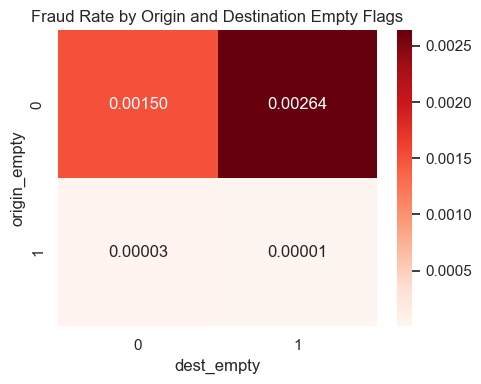

In [69]:
pivot = df_model.pivot_table(index='origin_empty', columns='dest_empty', values='isFraud', aggfunc='mean')
plt.figure(figsize=(5, 4))
sns.heatmap(pivot, annot=True, fmt=".5f", cmap='Reds')
plt.title("Fraud Rate by Origin and Destination Empty Flags")
plt.xlabel("dest_empty")
plt.ylabel("origin_empty")
plt.tight_layout()
plt.show()


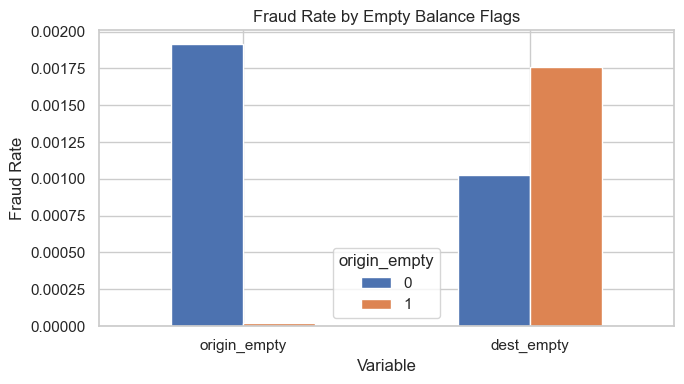

In [70]:
fraud_rates = df_model.groupby('origin_empty')['isFraud'].mean().rename('origin_empty').to_frame()
fraud_rates['dest_empty'] = df_model.groupby('dest_empty')['isFraud'].mean()

fraud_rates.T.plot(kind='bar', figsize=(7, 4), legend=True)
plt.title("Fraud Rate by Empty Balance Flags")
plt.xlabel("Variable")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


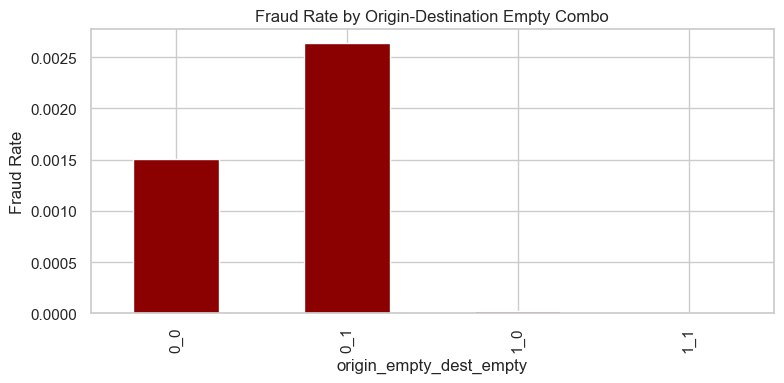

In [71]:
combo_rate.plot(kind='bar', color='darkred', figsize=(8, 4))
plt.title("Fraud Rate by Origin-Destination Empty Combo")
plt.xlabel("origin_empty_dest_empty")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


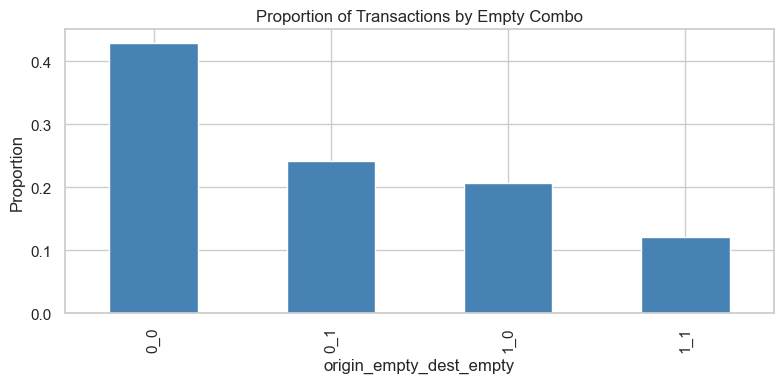

In [72]:
combo_count.plot(kind='bar', color='steelblue', figsize=(8, 4))
plt.title("Proportion of Transactions by Empty Combo")
plt.xlabel("origin_empty_dest_empty")
plt.ylabel("Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()


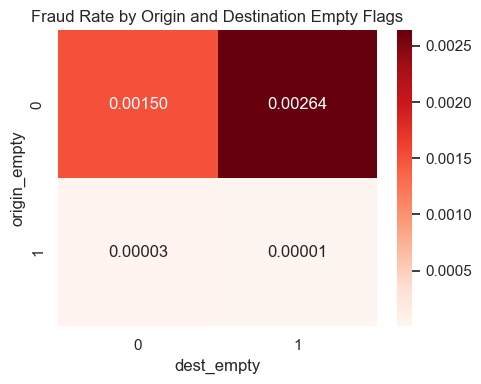

In [73]:
pivot = df_model.pivot_table(index='origin_empty', columns='dest_empty', values='isFraud', aggfunc='mean')
plt.figure(figsize=(5, 4))
sns.heatmap(pivot, annot=True, fmt=".5f", cmap='Reds')
plt.title("Fraud Rate by Origin and Destination Empty Flags")
plt.xlabel("dest_empty")
plt.ylabel("origin_empty")
plt.tight_layout()
plt.show()


### Section 6 – Empty Balances and Fraud

This section investigates the relationship between fraud and transactions involving accounts with zero balances before and after the transaction.

#### Binary Flags:
- `origin_empty`: Sender had a balance of zero both before and after the transaction.
- `dest_empty`: Receiver had a balance of zero both before and after the transaction.

#### Key Metrics:
- `origin_empty == 1`: 32.8% of all transactions, fraud rate: 0.002%
- `dest_empty == 1`: 36.4% of all transactions, fraud rate: 0.18%
- Fraud rate is significantly higher when `origin_empty == 0` and `dest_empty == 1` (0.26%)

#### Visualizations:
1. Barplot of fraud rate for `origin_empty` and `dest_empty`
2. Barplot of fraud rate for each binary combination (`0_0`, `0_1`, `1_0`, `1_1`)
3. Barplot of proportion of each combination in the dataset
4. Heatmap of fraud rate by origin and destination empty flags

#### Insights:
- Fraud is extremely rare when the origin account is empty.
- In contrast, destination accounts being empty is positively associated with higher fraud risk.
- The combination `origin_empty == 0` and `dest_empty == 1` exhibits the highest fraud rate.
- These binary indicators are meaningful features both individually and in combination.
- Feature engineering based on this analysis may include:
  - Direct use of `origin_empty` and `dest_empty`
  - A combined binary flag:
    ```python
    df_model['high_risk_empty_combo'] = ((df_model['origin_empty'] == 0) & (df_model['dest_empty'] == 1)).astype(int)
    ```

This behavioral pattern is highly relevant for fraud modeling and should be retained in the feature set.


In [74]:
# Flag per transazioni a importo zero
df_model['amount_zero'] = (df_model['amount'] == 0).astype(int)

# Statistiche
zero_amount_count = df_model['amount_zero'].sum()
total_count = len(df_model)
zero_amount_pct = zero_amount_count / total_count
fraud_in_zero = df_model[df_model['amount_zero'] == 1]['isFraud'].mean()
fraud_in_nonzero = df_model[df_model['amount_zero'] == 0]['isFraud'].mean()

print(f"Transactions with amount == 0: {zero_amount_count} ({zero_amount_pct:.2%})")
print(f"Fraud rate among amount == 0: {fraud_in_zero:.6f}")
print(f"Fraud rate among amount > 0: {fraud_in_nonzero:.6f}")


Transactions with amount == 0: 16 (0.00%)
Fraud rate among amount == 0: 1.000000
Fraud rate among amount > 0: 0.001288


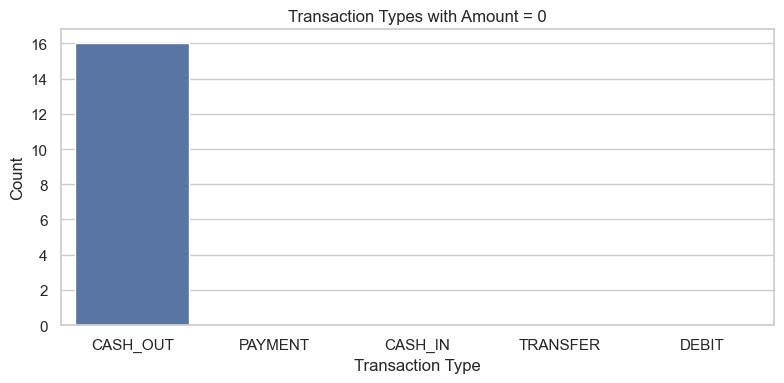

In [75]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_model[df_model['amount_zero'] == 1], x='type', order=df_model['type'].value_counts().index)
plt.title("Transaction Types with Amount = 0")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


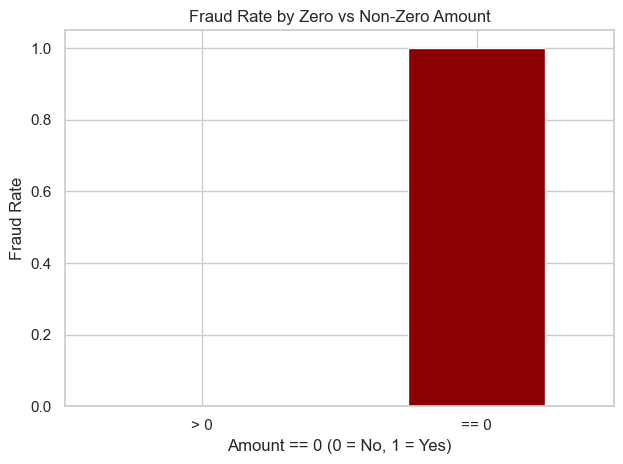

In [76]:
fraud_rate_zero = df_model.groupby('amount_zero')['isFraud'].mean()

fraud_rate_zero.plot(kind='bar', color=['steelblue', 'darkred'])
plt.title("Fraud Rate by Zero vs Non-Zero Amount")
plt.xlabel("Amount == 0 (0 = No, 1 = Yes)")
plt.ylabel("Fraud Rate")
plt.xticks(ticks=[0,1], labels=['> 0', '== 0'], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


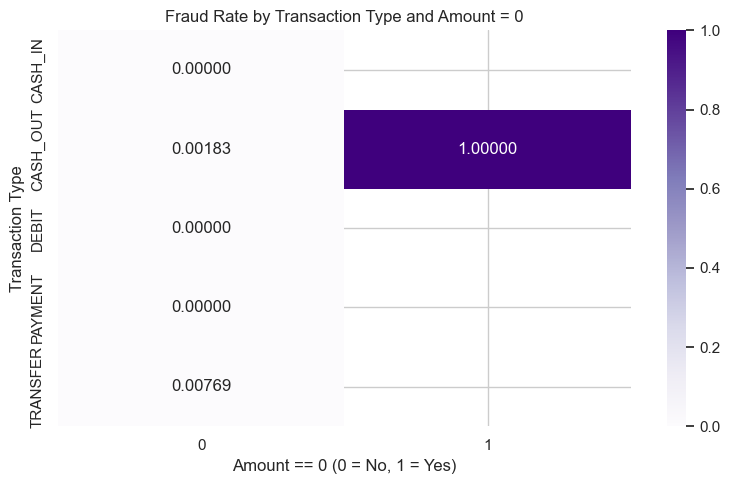

In [77]:
pivot = df_model.pivot_table(index='type', columns='amount_zero', values='isFraud', aggfunc='mean', observed=True)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".5f", cmap='Purples')
plt.title("Fraud Rate by Transaction Type and Amount = 0")
plt.xlabel("Amount == 0 (0 = No, 1 = Yes)")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


In [78]:
df_model['amount_zero'] = (df_model['amount'] == 0).astype(int)


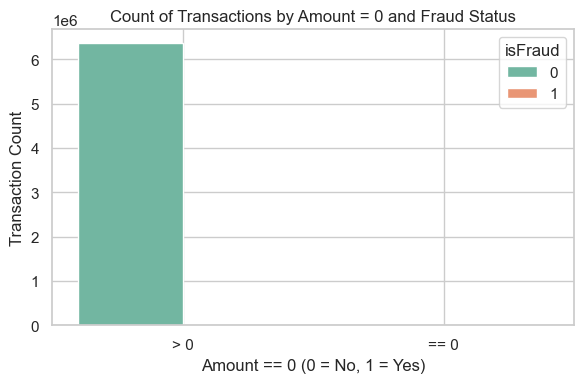

In [79]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_model, x='amount_zero', hue='isFraud', palette='Set2')
plt.title("Count of Transactions by Amount = 0 and Fraud Status")
plt.xlabel("Amount == 0 (0 = No, 1 = Yes)")
plt.ylabel("Transaction Count")
plt.xticks([0, 1], ['> 0', '== 0'])
plt.grid(True)
plt.tight_layout()
plt.show()


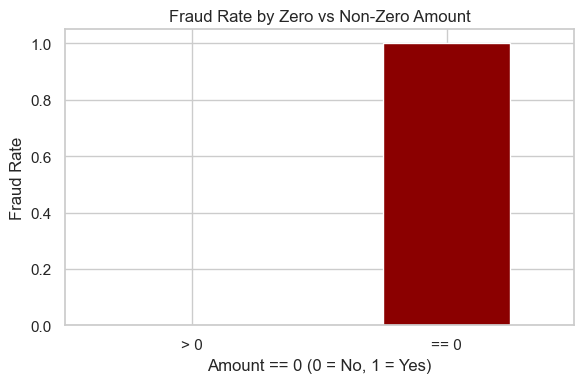

In [80]:
fraud_rate_zero = df_model.groupby('amount_zero')['isFraud'].mean()

fraud_rate_zero.plot(kind='bar', color=['steelblue', 'darkred'], figsize=(6, 4))
plt.title("Fraud Rate by Zero vs Non-Zero Amount")
plt.xlabel("Amount == 0 (0 = No, 1 = Yes)")
plt.ylabel("Fraud Rate")
plt.xticks(ticks=[0,1], labels=['> 0', '== 0'], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


### Section 7 – Analysis of Transactions with Amount = 0

This section examines transactions where the `amount` is exactly zero.

#### Key findings:
- There are 16 transactions with `amount == 0`, representing 0.00% of the dataset.
- All 16 of these transactions are fraudulent (100% fraud rate).
- In contrast, the fraud rate among transactions with `amount > 0` is only 0.13%.
- This makes `amount == 0` the most extreme and pure indicator of fraud in the entire dataset.

#### Visualizations:
1. Countplot of transactions with `amount == 0`, split by `isFraud`
2. Barplot comparing fraud rate between `amount == 0` and `amount > 0`

#### Insights:
- The fact that every zero-amount transaction is fraudulent suggests a system-level anomaly or a crafted attack pattern.
- This group is very small, but extremely informative.
- The binary feature `amount_zero` should be retained as a high-precision fraud indicator in modeling.



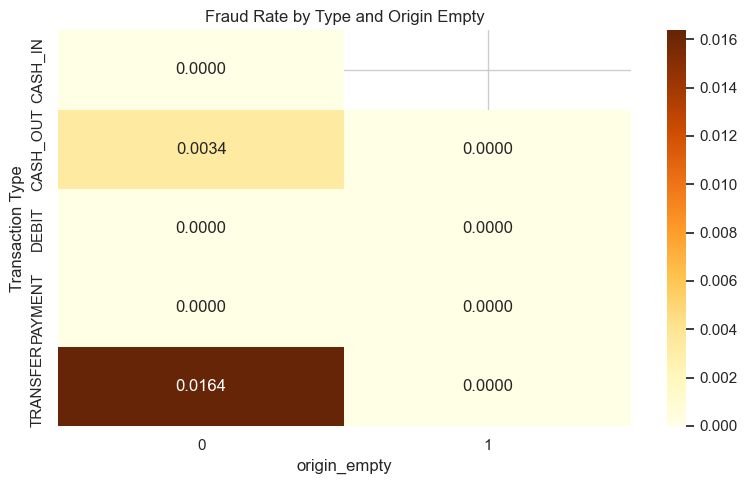

In [81]:
pivot = df_model.pivot_table(index='type', columns='origin_empty', values='isFraud', aggfunc='mean', observed=True)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap='YlOrBr')
plt.title("Fraud Rate by Type and Origin Empty")
plt.xlabel("origin_empty")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


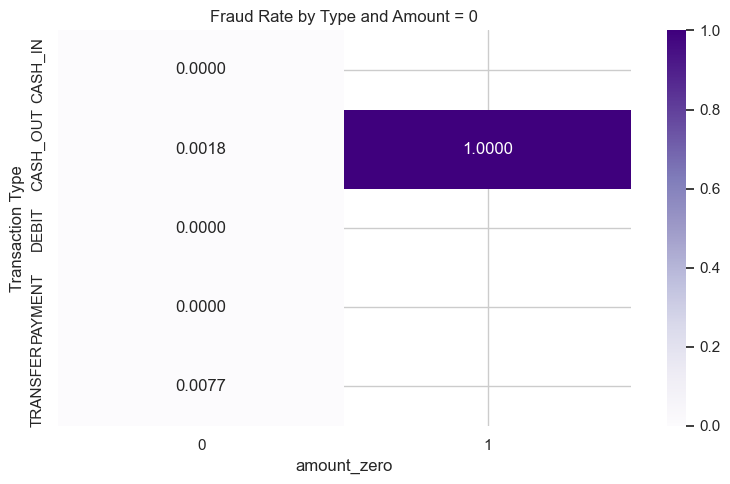

In [82]:
pivot2 = df_model.pivot_table(index='type', columns='amount_zero', values='isFraud', aggfunc='mean', observed=True)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot2, annot=True, fmt=".4f", cmap='Purples')
plt.title("Fraud Rate by Type and Amount = 0")
plt.xlabel("amount_zero")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1973422042.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette='viridis')


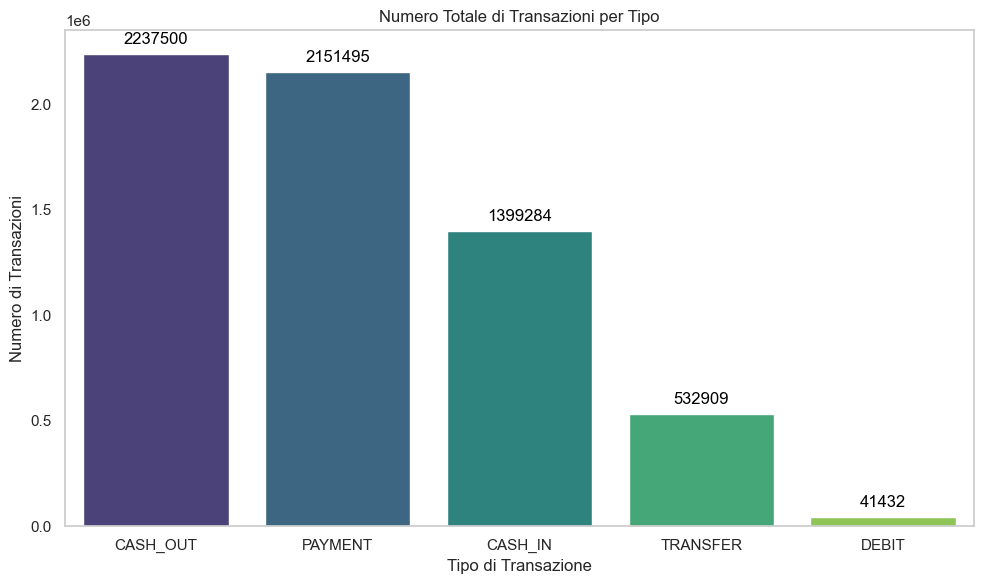

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolo del numero totale di transazioni per tipo
transaction_counts = df_model['type'].value_counts()

# Creazione del bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=transaction_counts.index, y=transaction_counts.values, palette='viridis')

# Aggiunta delle etichette numeriche sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Impostazioni del grafico
plt.title('Numero Totale di Transazioni per Tipo')
plt.xlabel('Tipo di Transazione')
plt.ylabel('Numero di Transazioni')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\2771391876.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='magma')


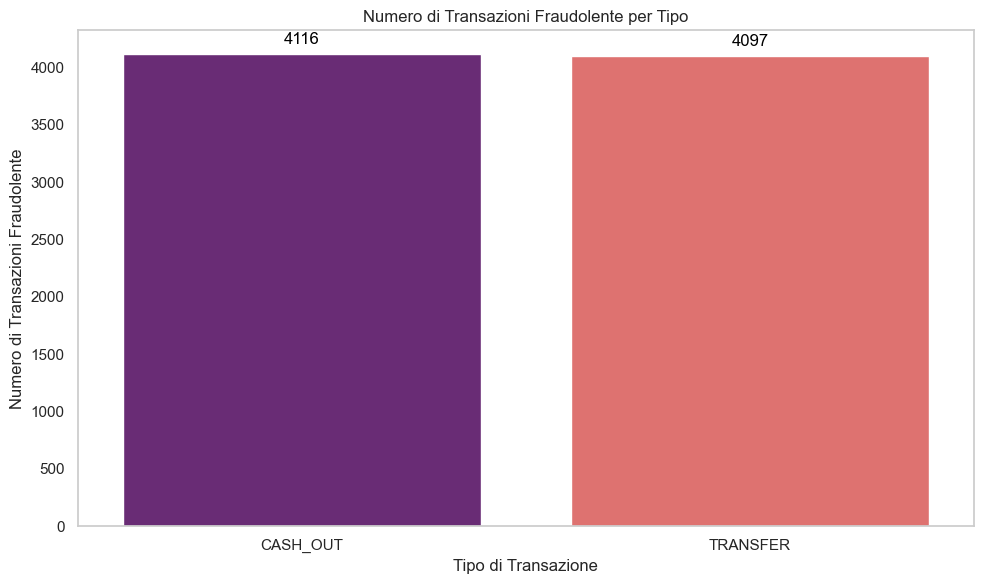

In [84]:
# Filtraggio delle transazioni fraudolente e conteggio per tipo
fraud_counts = df_model[df_model['isFraud'] == 1]['type'].value_counts()

# Creazione del bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='magma')

# Aggiunta delle etichette numeriche sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Impostazioni del grafico
plt.title('Numero di Transazioni Fraudolente per Tipo')
plt.xlabel('Tipo di Transazione')
plt.ylabel('Numero di Transazioni Fraudolente')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\2606524219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='coolwarm')


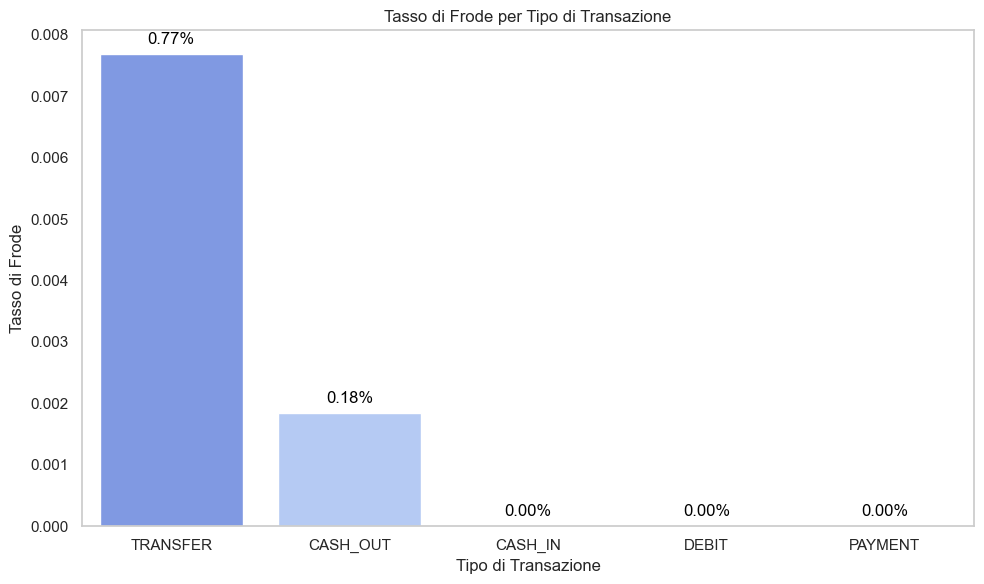

In [85]:
# Calcolo del tasso di frode per tipo di transazione
fraud_rate = df_model.groupby('type')['isFraud'].mean().sort_values(ascending=False)

# Creazione del bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='coolwarm')

# Aggiunta delle etichette numeriche sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Impostazioni del grafico
plt.title('Tasso di Frode per Tipo di Transazione')
plt.xlabel('Tipo di Transazione')
plt.ylabel('Tasso di Frode')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Section 8 – Transaction Type Combinations and Fraud

This section explores how fraud is distributed across transaction types and how it interacts with other binary flags.

#### Visualizations:
1. Fraud rate per transaction type (ordered barplot)
2. Absolute number of frauds per transaction type
3. Heatmap of fraud rate by `type` and `origin_empty`
4. Heatmap of fraud rate by `type` and `amount_zero`

#### Insights:
- Fraud is concentrated almost entirely in `TRANSFER` and `CASH_OUT` transactions.
- All other types (`PAYMENT`, `CASH_IN`, `DEBIT`) show negligible or zero fraud.
- Within fraudulent types, certain combinations (e.g., `TRANSFER` + `amount_zero`, `CASH_OUT` + `origin_empty = 0`) present elevated risk.
- These interactions justify combining categorical and binary flags in new features.


In [86]:
df_model['transfer_origin_empty'] = ((df_model['type'] == 'TRANSFER') & (df_model['origin_empty'] == 1)).astype(int)
df_model['cashout_zero_amount'] = ((df_model['type'] == 'CASH_OUT') & (df_model['amount_zero'] == 1)).astype(int)

In [87]:
# Creazione di una feature combinata per `TRANSFER` e `amount_zero`
df_model['transfer_zero_amount'] = ((df_model['type'] == 'TRANSFER') & (df_model['amount_zero'] == 1)).astype(int)

# Controllo
df_model[['type', 'amount_zero', 'transfer_zero_amount']].head()


,type,amount_zero,transfer_zero_amount
0,PAYMENT,0,0
1,PAYMENT,0,0
2,TRANSFER,0,0
3,CASH_OUT,0,0
4,PAYMENT,0,0


In [88]:
# Creazione di una feature combinata per `CASH_OUT` e `origin_empty`
df_model['cashout_origin_empty'] = ((df_model['type'] == 'CASH_OUT') & (df_model['origin_empty'] == 1)).astype(int)

# Controllo
df_model[['type', 'origin_empty', 'cashout_origin_empty']].head()


,type,origin_empty,cashout_origin_empty
0,PAYMENT,0,0
1,PAYMENT,0,0
2,TRANSFER,0,0
3,CASH_OUT,0,0
4,PAYMENT,0,0


In [89]:
# Creazione di una feature combinata per `TRANSFER` e `dest_empty`
df_model['transfer_dest_empty'] = ((df_model['type'] == 'TRANSFER') & (df_model['dest_empty'] == 1)).astype(int)

# Controllo
df_model[['type', 'dest_empty', 'transfer_dest_empty']].head()


,type,dest_empty,transfer_dest_empty
0,PAYMENT,1,0
1,PAYMENT,1,0
2,TRANSFER,1,1
3,CASH_OUT,0,0
4,PAYMENT,1,0


In [90]:
# Creazione di una feature combinata per `CASH_IN` e `amount_zero`
df_model['cashin_zero_amount'] = ((df_model['type'] == 'CASH_IN') & (df_model['amount_zero'] == 1)).astype(int)

# Controllo
df_model[['type', 'amount_zero', 'cashin_zero_amount']].head()



,type,amount_zero,cashin_zero_amount
0,PAYMENT,0,0
1,PAYMENT,0,0
2,TRANSFER,0,0
3,CASH_OUT,0,0
4,PAYMENT,0,0


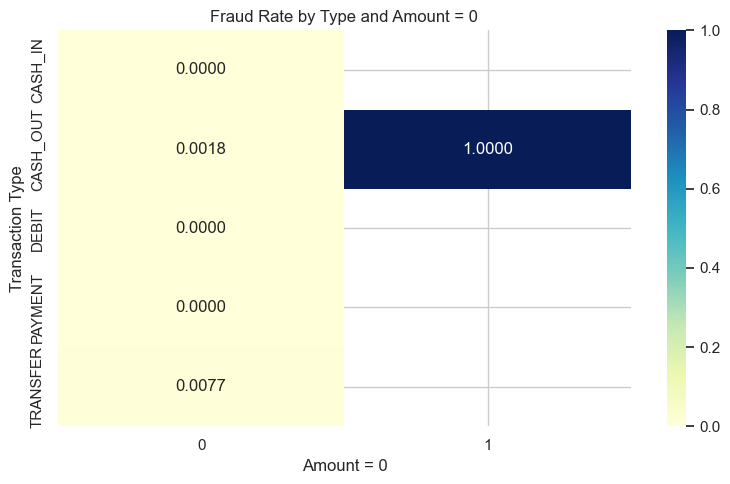

In [91]:
# Creazione di una heatmap per combinazioni binarie di `type` e altre variabili
pivot = df_model.pivot_table(index='type', columns='amount_zero', values='isFraud', aggfunc='mean', observed=True)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("Fraud Rate by Type and Amount = 0")
plt.xlabel("Amount = 0")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()


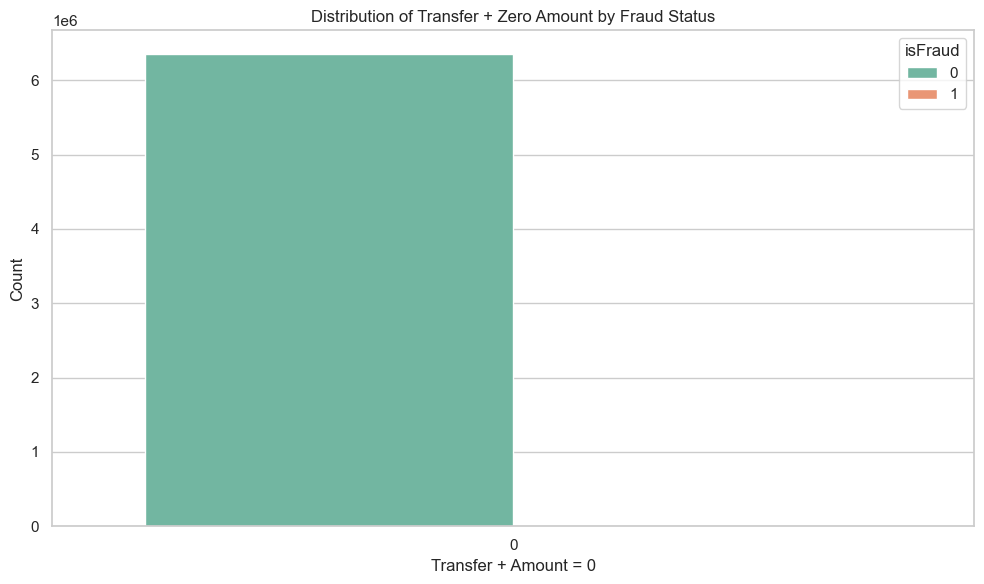

In [92]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, x='transfer_zero_amount', hue='isFraud', palette='Set2')
plt.title("Distribution of Transfer + Zero Amount by Fraud Status")
plt.xlabel("Transfer + Amount = 0")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


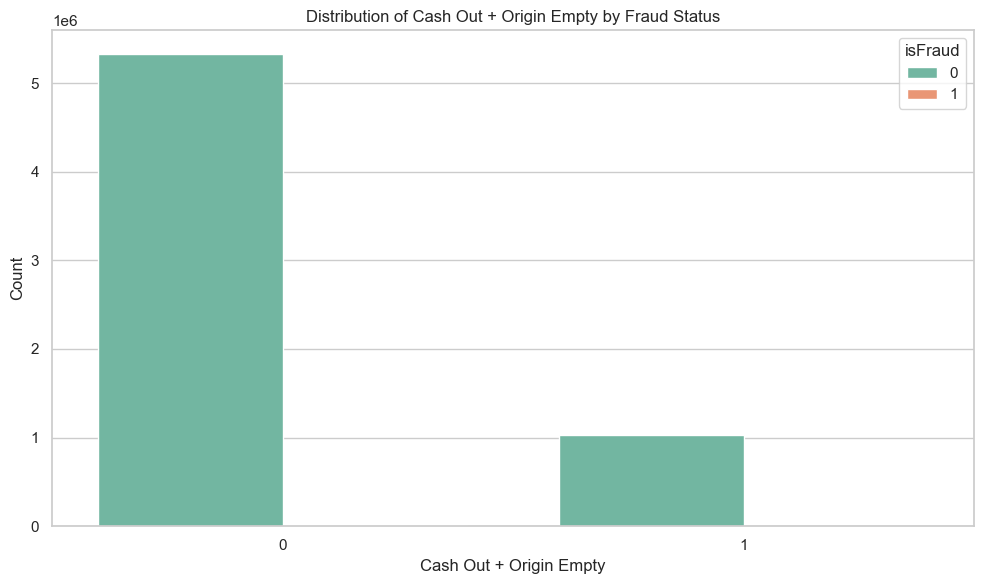

In [93]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, x='cashout_origin_empty', hue='isFraud', palette='Set2')
plt.title("Distribution of Cash Out + Origin Empty by Fraud Status")
plt.xlabel("Cash Out + Origin Empty")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


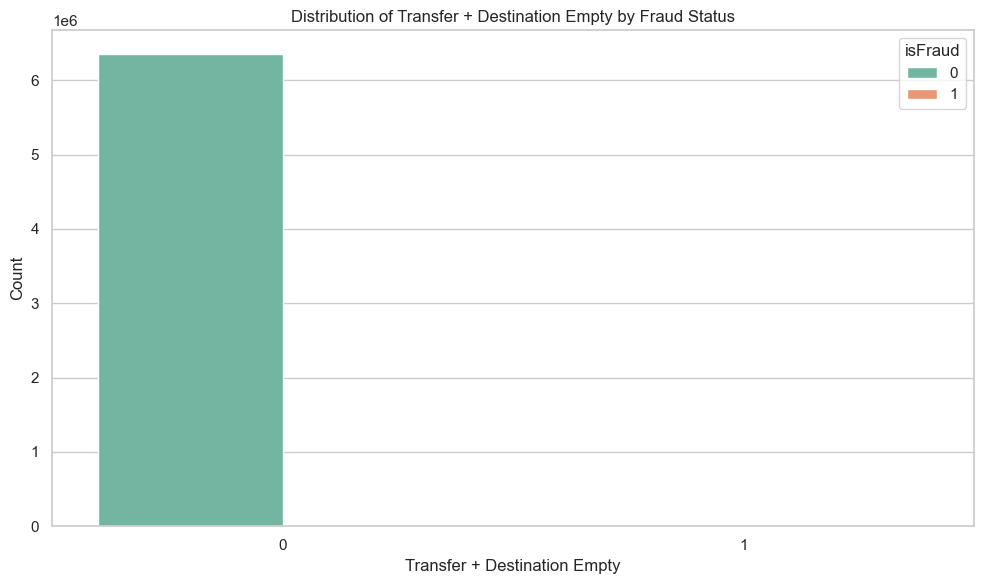

In [94]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, x='transfer_dest_empty', hue='isFraud', palette='Set2')
plt.title("Distribution of Transfer + Destination Empty by Fraud Status")
plt.xlabel("Transfer + Destination Empty")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


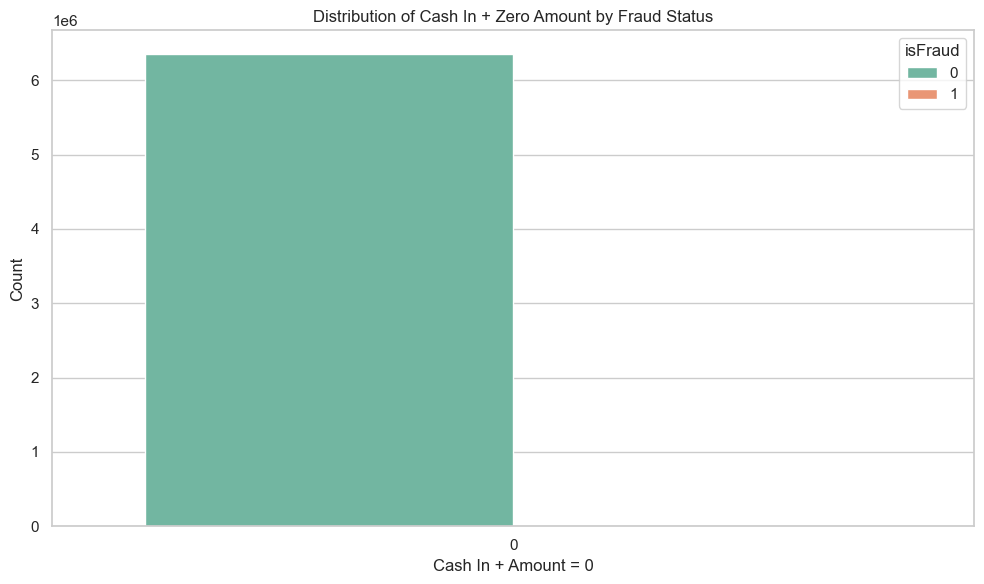

In [95]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model, x='cashin_zero_amount', hue='isFraud', palette='Set2')
plt.title("Distribution of Cash In + Zero Amount by Fraud Status")
plt.xlabel("Cash In + Amount = 0")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### Section 9 – Feature Engineering for Binary Combinations and Transaction Types

This section focuses on creating new binary features by combining transaction types with other binary flags such as `amount_zero`, `origin_empty`, and `dest_empty`. These feature combinations are intended to capture more complex interactions that could be indicative of fraud.

#### Feature Creation:
1. `transfer_zero_amount`: Combines the `TRANSFER` transaction type and `amount == 0`.
2. `cashout_origin_empty`: Combines the `CASH_OUT` transaction type and `origin_empty == 1`.
3. `transfer_dest_empty`: Combines the `TRANSFER` transaction type and `dest_empty == 1`.
4. `cashin_zero_amount`: Combines the `CASH_IN` transaction type and `amount == 0`.

#### Insights:
- The combinations of `TRANSFER` and `amount_zero`, and `CASH_OUT` with `origin_empty`, create features that highlight potentially risky transactions. While these combinations are rare, they could have a significant impact on fraud prediction.
- These feature combinations may enhance the predictive power of the model, especially for detecting fraud in transaction types that might not be heavily flagged on their own.

In [96]:
df_model['transfer_zero_amount'] = ((df_model['type'] == 'TRANSFER') & (df_model['amount_zero'] == 1)).astype(int)
df_model['cashout_origin_empty'] = ((df_model['type'] == 'CASH_OUT') & (df_model['origin_empty'] == 1)).astype(int)
df_model['transfer_dest_empty'] = ((df_model['type'] == 'TRANSFER') & (df_model['dest_empty'] == 1)).astype(int)
df_model['cashin_zero_amount'] = ((df_model['type'] == 'CASH_IN') & (df_model['amount_zero'] == 1)).astype(int)

In [97]:
from sklearn.model_selection import train_test_split

# Definizione delle feature (tutte le colonne tranne 'isFraud')
X = df_model.drop(columns=['isFraud'])

# Definizione del target (la variabile che vogliamo predire)
y = df_model['isFraud']

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


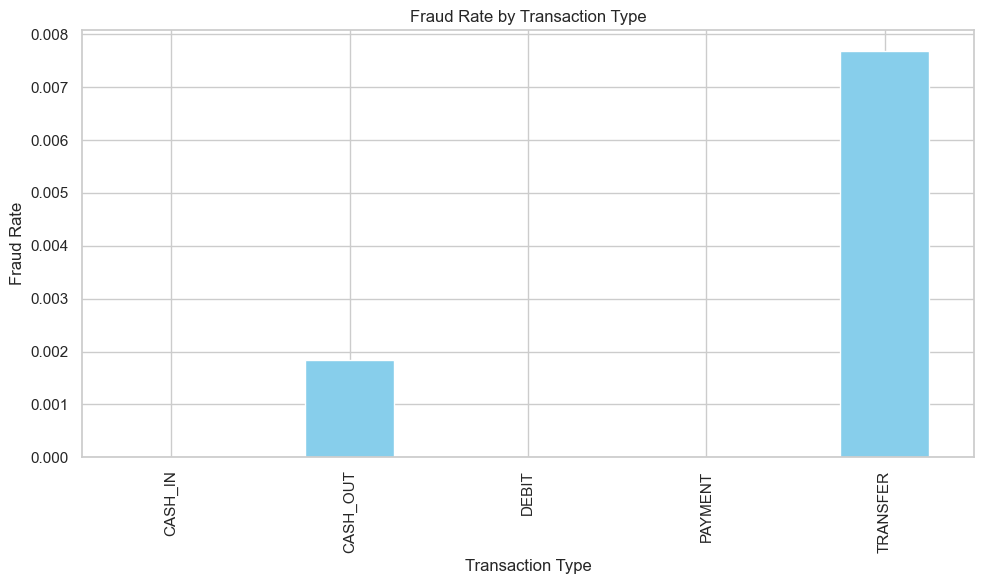

In [99]:
# Analisi delle associazioni tra variabili categoriali
fraud_by_type = df_model.groupby('type')['isFraud'].mean()

plt.figure(figsize=(10, 6))
fraud_by_type.plot(kind='bar', color='skyblue')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1037331456.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_model, palette='Set2')


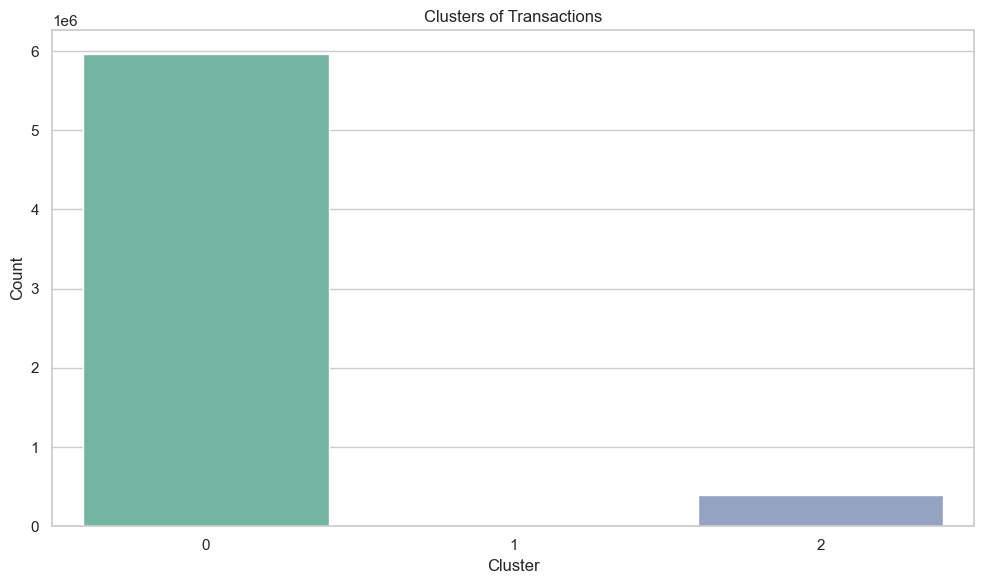

In [100]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pre-elaborazione dei dati: Normalizzazione per il clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model.select_dtypes(include=['float64', 'int64']))

# Esecuzione del clustering KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizzazione dei gruppi
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_model, palette='Set2')
plt.title('Clusters of Transactions')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\3718354969.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=df_model, palette='Set1')


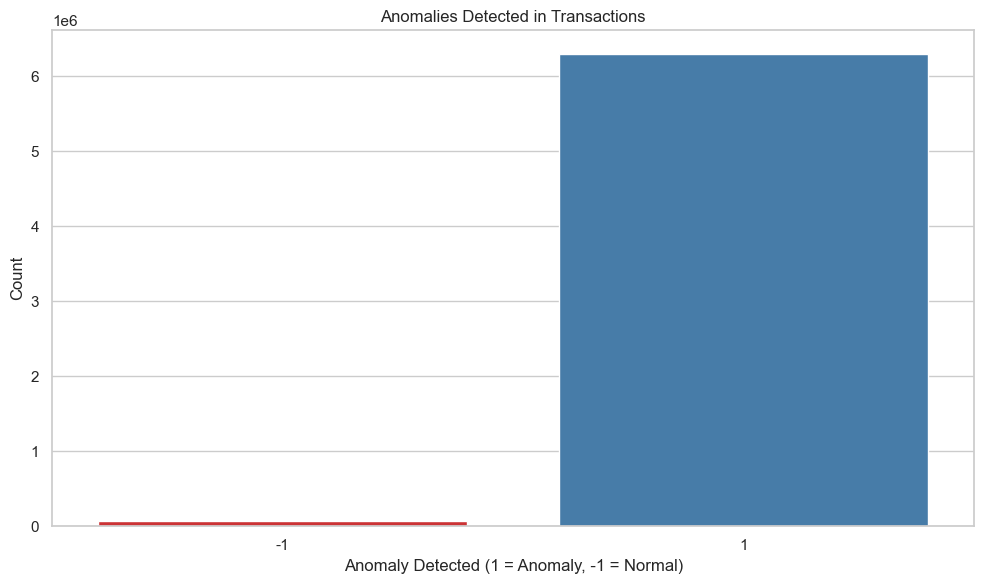

In [101]:
from sklearn.ensemble import IsolationForest

# Creazione del modello di rilevamento delle anomalie
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Rilevamento anomalie
df_model['anomaly'] = iso_forest.fit_predict(X_scaled)

# Visualizzazione delle anomalie
plt.figure(figsize=(10, 6))
sns.countplot(x='anomaly', data=df_model, palette='Set1')
plt.title('Anomalies Detected in Transactions')
plt.xlabel('Anomaly Detected (1 = Anomaly, -1 = Normal)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\4099942933.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')


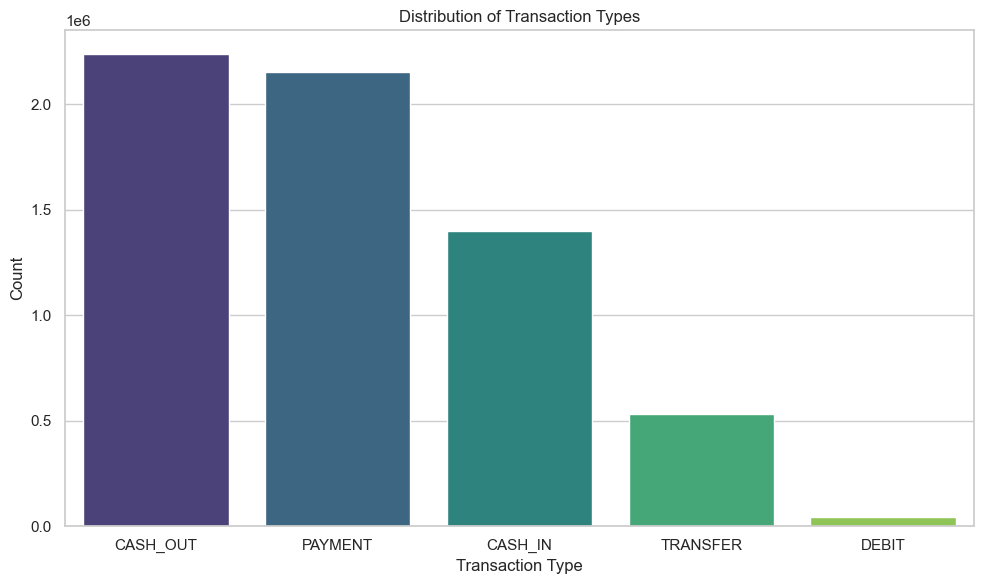

In [103]:
# Analisi della distribuzione delle transazioni per tipologia
type_counts = df_model['type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [104]:
# Estrai un campione casuale del 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Verifica la dimensione del campione
print(f"Campione ridotto, numero di righe: {df_sample.shape[0]}")

# Separare le feature e il target
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

# Divisione in train e test (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Mostra la distribuzione delle classi nel campione
print(f"Distribuzione delle classi nel campione: {y_sample.value_counts()}")


Campione ridotto, numero di righe: 636262
Distribuzione delle classi nel campione: isFraud
0    635445
1       817
Name: count, dtype: int64


In [107]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Separare le feature e il target
X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

# Creare un trasformatore che esegue One-Hot Encoding sulle variabili categoriche
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['type'])  # 'type' è la colonna categorica
    ], 
    remainder='passthrough'  # Le altre colonne numeriche vengono lasciate intatte
)

# Applicare One-Hot Encoding
X_encoded = column_transformer.fit_transform(X)

# Applicare SMOTE per il bilanciamento
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)

# Verifica la distribuzione delle classi dopo il bilanciamento
print(f"Distribuzione delle classi dopo SMOTE: {y_res.value_counts()}")

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Mostra la distribuzione delle classi nel dataset bilanciato
print(f"Distribuzione delle classi nel dataset bilanciato: {y_res.value_counts()}")


Distribuzione delle classi dopo SMOTE: isFraud
0    6354407
1    6354407
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato: isFraud
0    6354407
1    6354407
Name: count, dtype: int64


Accuracy: 0.9107
Precision: 0.9197
Recall: 0.9000
F1-score: 0.9098


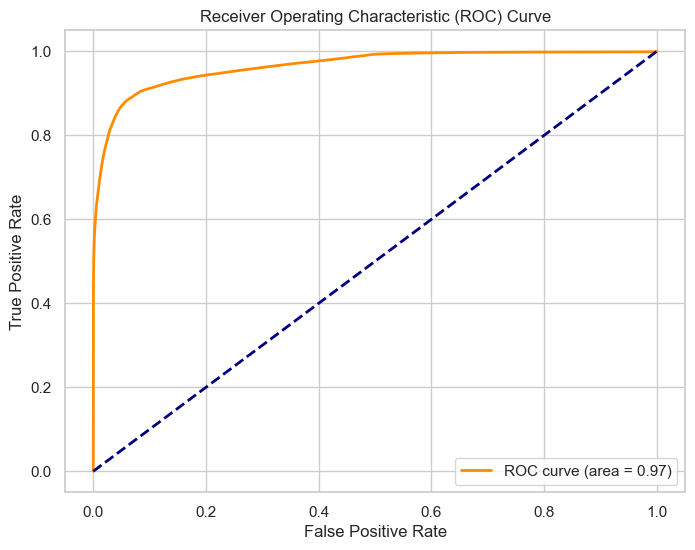

C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1272686292.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


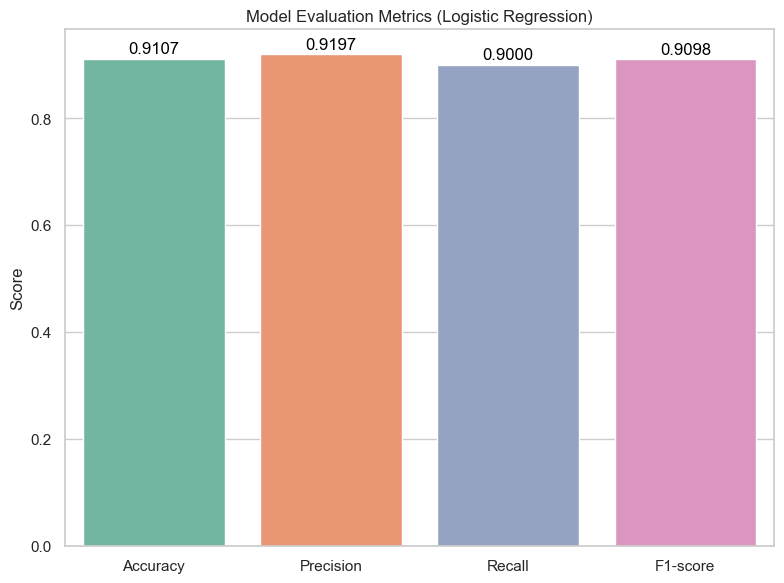

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Creazione del modello Logistic Regression
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Addestramento
logreg.fit(X_train, y_train)

# Previsione
y_pred = logreg.predict(X_test)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Visualizzazione delle metriche
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Curve ROC
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot delle curve ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Istogrammi delle metriche
metrics = [accuracy, precision, recall, f1]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')
for i, value in enumerate(metrics):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, color='black')
plt.title('Model Evaluation Metrics (Logistic Regression)')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


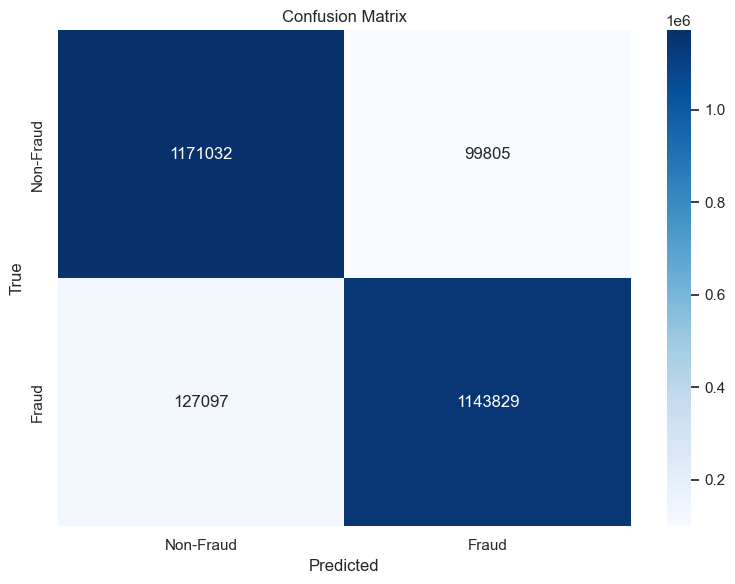

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcolare la confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizzare la confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [110]:
from sklearn.metrics import matthews_corrcoef

# Calcolare il Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.8217


Area Under Precision-Recall Curve (AUC-PR): 0.9702


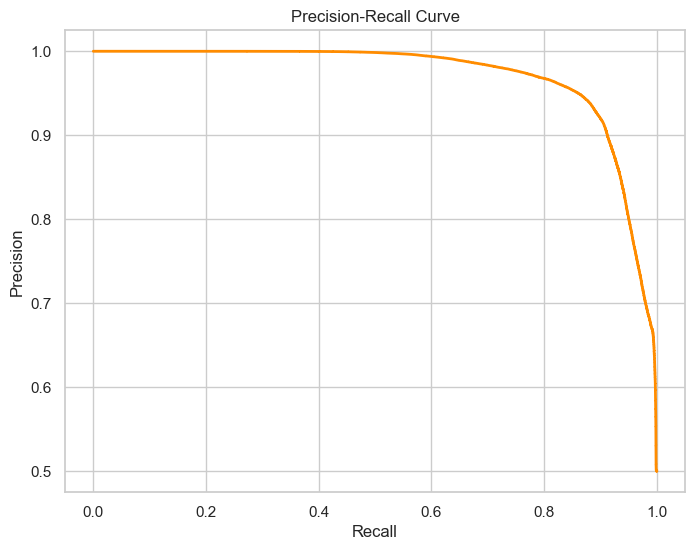

In [111]:
from sklearn.metrics import precision_recall_curve, auc

# Calcolare precision e recall
precision, recall, _ = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:, 1])

# Calcolare AUC-PR
auc_pr = auc(recall, precision)
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.4f}")

# Plot della Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [112]:
from sklearn.metrics import log_loss

# Calcolare log loss
logloss = log_loss(y_test, logreg.predict_proba(X_test))
print(f"Log Loss: {logloss:.4f}")


Log Loss: 0.2932


In [113]:
from sklearn.metrics import fbeta_score

# Calcolare F-Beta Score con β=2
fbeta = fbeta_score(y_test, y_pred, beta=2)
print(f"F-Beta Score (beta=2): {fbeta:.4f}")


F-Beta Score (beta=2): 0.9039


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\521932638.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


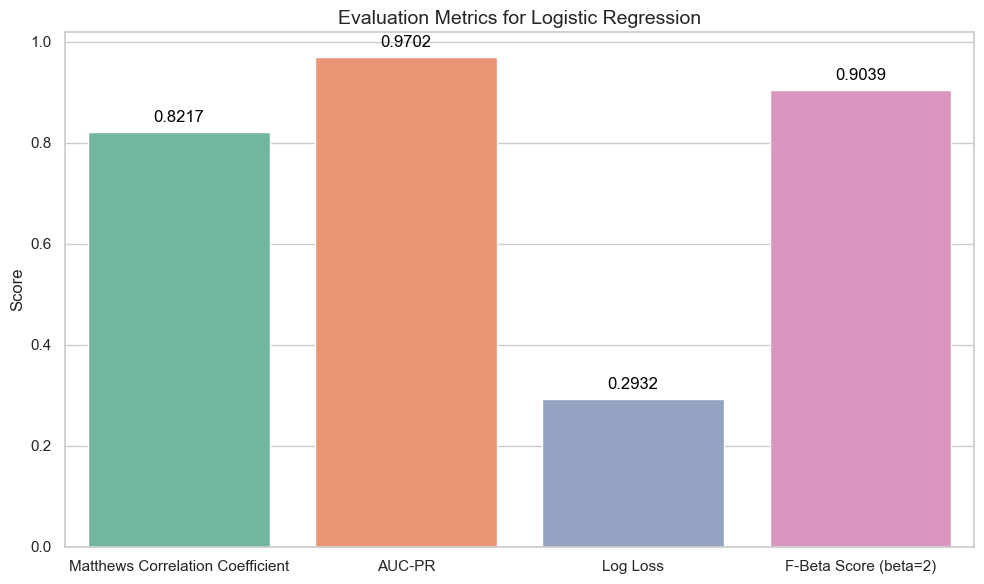

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metriche da visualizzare
metrics = [0.8217, 0.9702, 0.2932, 0.9039]
metric_labels = ['Matthews Correlation Coefficient', 'AUC-PR', 'Log Loss', 'F-Beta Score (beta=2)']

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')

# Aggiungere le etichette numeriche sopra le barre
for i, value in enumerate(metrics):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')

# Titolo e etichette
plt.title('Evaluation Metrics for Logistic Regression', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()
plt.show()


Accuracy: 0.7961
Precision: 0.9530
Recall: 0.6226
F1-score: 0.7532


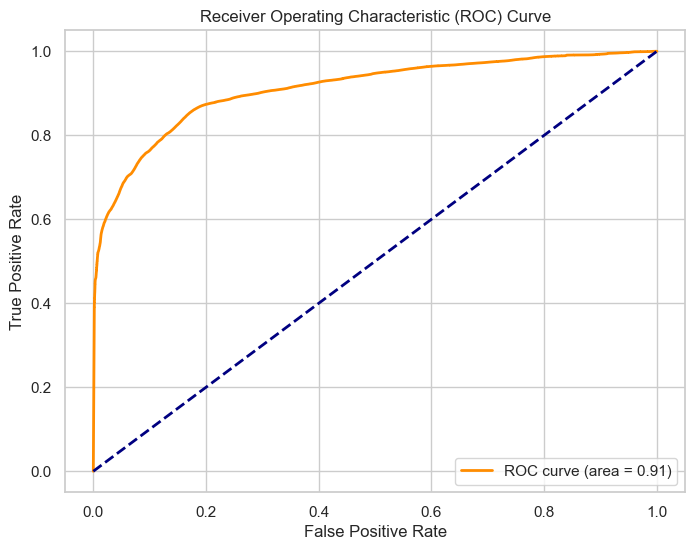

In [118]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Creazione del campione al 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Separare le feature e il target
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

# Creare un trasformatore che esegue One-Hot Encoding sulle variabili categoriche
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['type'])  # 'type' è la colonna categorica
    ], 
    remainder='passthrough'
)

# Applicare One-Hot Encoding alle variabili categoriche
X_encoded = column_transformer.fit_transform(X_sample)

# Applicare SMOTE per il bilanciamento delle classi
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_sample)

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Creazione del modello Naive Bayes
nb = GaussianNB()

# Addestramento
nb.fit(X_train, y_train)

# Previsione
y_pred = nb.predict(X_test)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Visualizzazione delle metriche
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Curve ROC
fpr, tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot delle curve ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1473373418.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


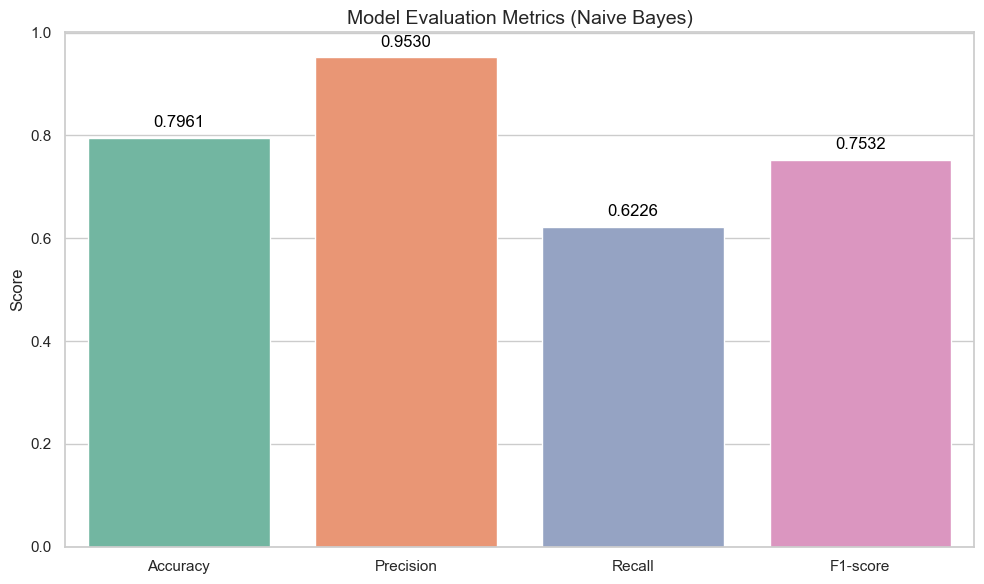

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metriche da visualizzare
metrics = [0.7961, 0.9530, 0.6226, 0.7532]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')

# Aggiungere le etichette numeriche sopra le barre
for i, value in enumerate(metrics):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')

# Titolo e etichette
plt.title('Model Evaluation Metrics (Naive Bayes)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()
plt.show()


In [120]:
from sklearn.metrics import matthews_corrcoef

# Calcolare il Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.6312


Area Under Precision-Recall Curve (AUC-PR): 0.9260


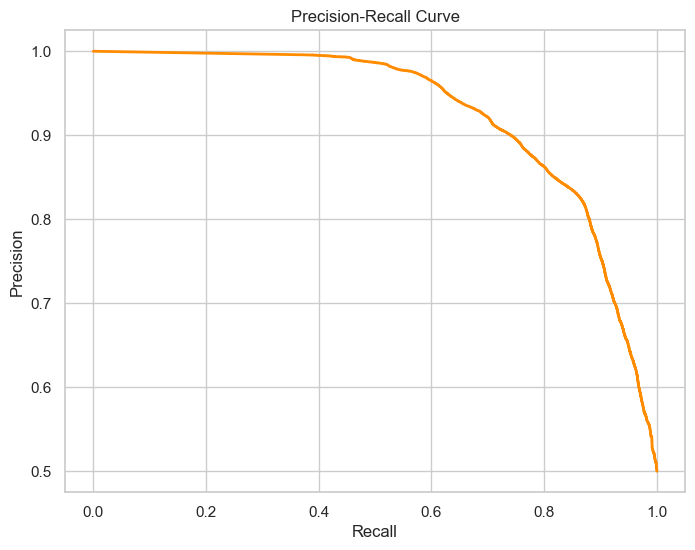

In [121]:
from sklearn.metrics import precision_recall_curve, auc

# Calcolare precision e recall
precision, recall, _ = precision_recall_curve(y_test, nb.predict_proba(X_test)[:, 1])

# Calcolare AUC-PR
auc_pr = auc(recall, precision)
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.4f}")

# Plot della Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [122]:
from sklearn.metrics import log_loss

# Calcolare log loss
logloss = log_loss(y_test, nb.predict_proba(X_test))
print(f"Log Loss: {logloss:.4f}")


Log Loss: 0.6878


In [123]:
from sklearn.metrics import fbeta_score

# Calcolare F-Beta Score con β=2
fbeta = fbeta_score(y_test, y_pred, beta=2)
print(f"F-Beta Score (beta=2): {fbeta:.4f}")


F-Beta Score (beta=2): 0.6690


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\1982488296.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


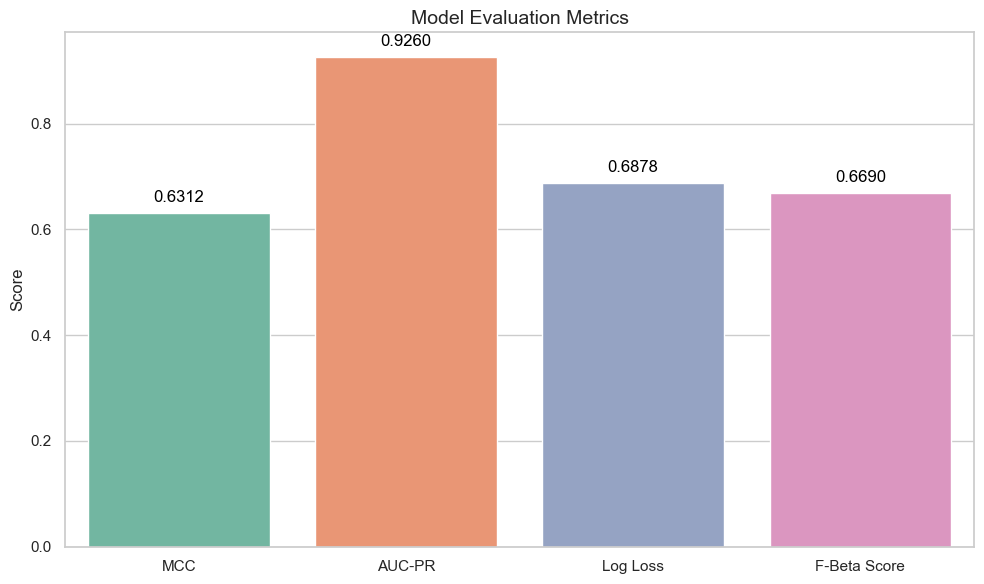

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metriche da visualizzare
metrics = [0.6312, 0.9260, 0.6878, 0.6690]
metric_labels = ['MCC', 'AUC-PR', 'Log Loss', 'F-Beta Score']

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')

# Aggiungere le etichette numeriche sopra le barre
for i, value in enumerate(metrics):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')

# Titolo e etichette
plt.title('Model Evaluation Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 508430, number of negative: 508282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4812
[LightGBM] [Info] Number of data points in the train set: 1016712, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500073 -> initscore=0.000291
[LightGBM] [Info] Start training from score 0.000291


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\21738607.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


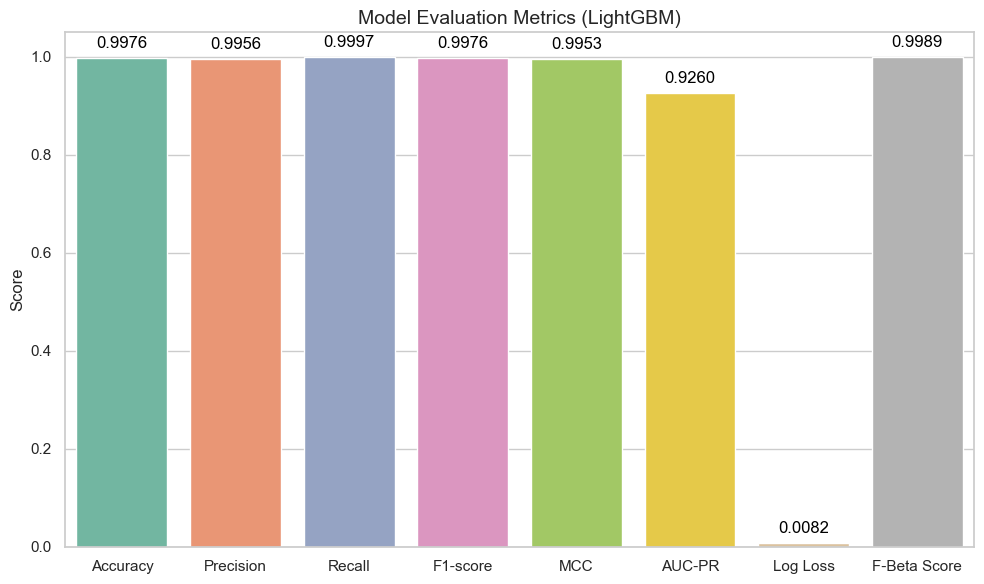

Accuracy: 0.9976
Precision: 0.9956
Recall: 0.9997
F1-score: 0.9976
MCC: 0.9953
AUC-PR: 1.0000
Log Loss: 0.0082
F-Beta Score: 0.9989


In [124]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, log_loss, matthews_corrcoef, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Creazione del campione al 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Separare le feature e il target
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

# Creare un trasformatore che esegue One-Hot Encoding sulle variabili categoriche
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['type', 'empty_combo'])  # 'type' e 'empty_combo' sono le colonne categoriche
    ], 
    remainder='passthrough'
)

# Applicare One-Hot Encoding
X_encoded = column_transformer.fit_transform(X_sample)

# Applicare SMOTE per il bilanciamento delle classi
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_sample)

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Creazione del modello LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)

# Addestramento
lgbm.fit(X_train, y_train)

# Previsione
y_pred = lgbm.predict(X_test)
y_pred_prob = lgbm.predict_proba(X_test)[:, 1]

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Altre metriche
mcc = matthews_corrcoef(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
logloss = log_loss(y_test, y_pred_prob)
fbeta = fbeta_score(y_test, y_pred, beta=2)

# Visualizzazione delle metriche
metrics = [accuracy, precision, recall, f1, mcc, auc_pr, logloss, fbeta]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'MCC', 'AUC-PR', 'Log Loss', 'F-Beta Score']

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')

# Aggiungere le etichette numeriche sopra le barre
for i, value in enumerate(metrics):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')

# Titolo e etichette
plt.title('Model Evaluation Metrics (LightGBM)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()
plt.show()

# Stampa delle metriche
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"AUC-PR: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"F-Beta Score: {fbeta:.4f}")


In [130]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Creazione del campione al 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Separare le feature e il target
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

# Creare un trasformatore che esegue One-Hot Encoding sulle variabili categoriche
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['type', 'empty_combo'])  # 'type' e 'empty_combo' sono le colonne categoriche
    ], 
    remainder='passthrough'
)

# Applicare One-Hot Encoding
X_encoded = column_transformer.fit_transform(X_sample)

# Applicare SMOTE per il bilanciamento delle classi
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_sample)

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Creazione del modello XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Addestramento
xgb_model.fit(X_train, y_train)

# Previsione
y_pred = xgb_model.predict(X_test)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Visualizzazione delle metriche
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9987
Precision: 0.9976
Recall: 0.9999
F1-score: 0.9987


Accuracy: 0.9987
Precision: 0.9976
Recall: 0.9999
F1-score: 0.9987
Matthews Correlation Coefficient (MCC): 0.9975
AUC-PR: 1.0000
Log Loss: 0.0048
F-Beta Score (beta=2): 0.9994


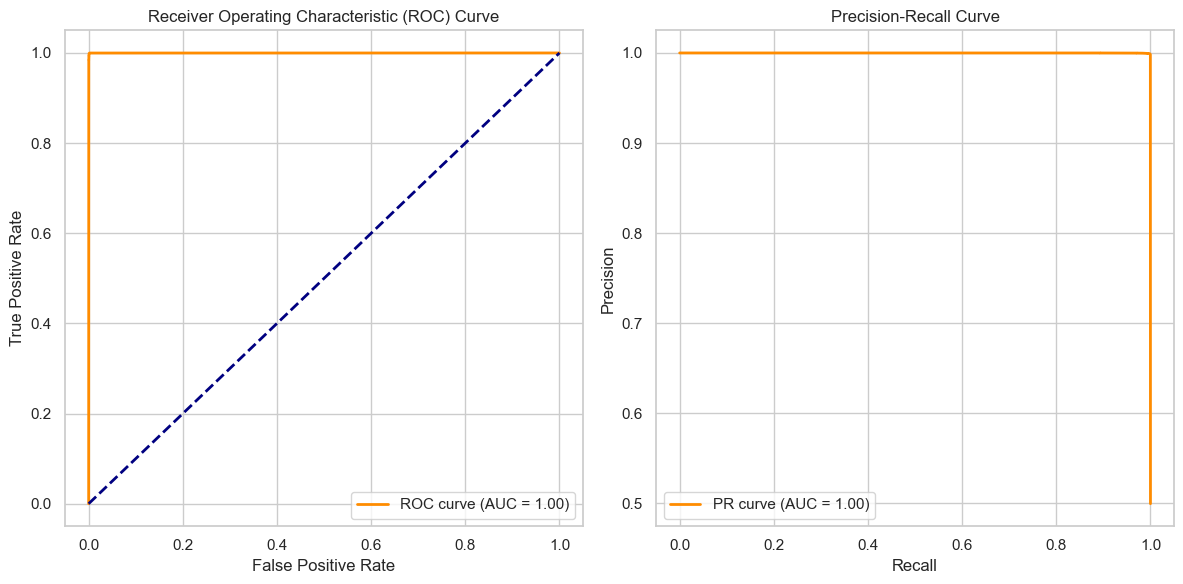

In [131]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, log_loss, matthews_corrcoef, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Creazione del campione al 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Separare le feature e il target
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

# Creare un trasformatore che esegue One-Hot Encoding sulle variabili categoriche
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['type', 'empty_combo'])  # 'type' e 'empty_combo' sono le colonne categoriche
    ], 
    remainder='passthrough'
)

# Applicare One-Hot Encoding
X_encoded = column_transformer.fit_transform(X_sample)

# Applicare SMOTE per il bilanciamento delle classi
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_sample)

# Divisione in train e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Creazione del modello XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Addestramento
xgb_model.fit(X_train, y_train)

# Previsione
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Altre metriche
mcc = matthews_corrcoef(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
logloss = log_loss(y_test, y_pred_prob)
fbeta = fbeta_score(y_test, y_pred, beta=2)

# Stampa delle metriche
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"AUC-PR: {auc(fpr, tpr):.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"F-Beta Score (beta=2): {fbeta:.4f}")

# Plot ROC Curve e Precision-Recall Curve
plt.figure(figsize=(12, 6))

# Subplot per la ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Calcolare Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall_curve, precision_curve)

# Subplot per la Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Mostrare entrambi i grafici
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\3950543276.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metrics, palette='Set2')


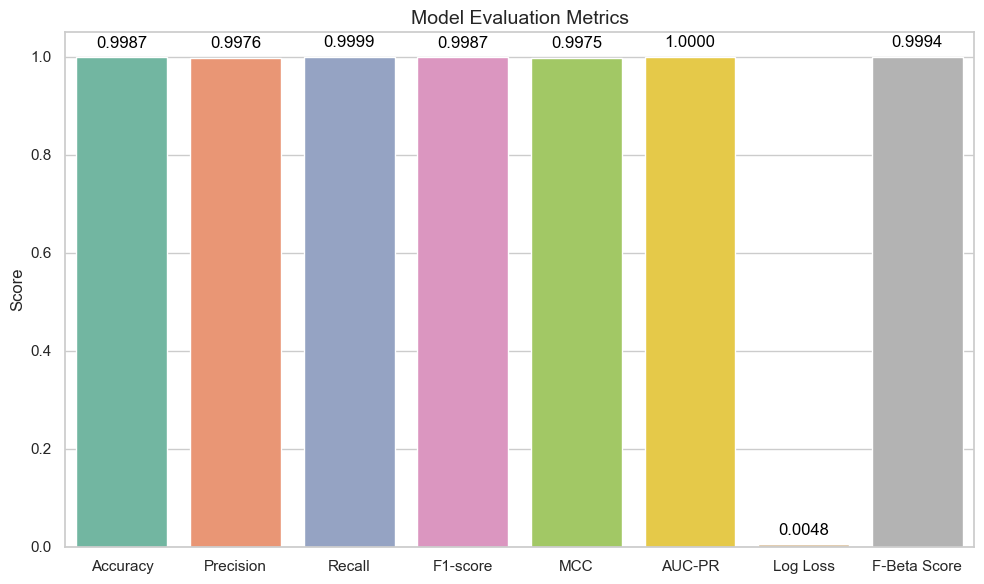

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metriche da visualizzare
metrics = [
    0.9987,  # Accuracy
    0.9976,  # Precision
    0.9999,  # Recall
    0.9987,  # F1-score
    0.9975,  # Matthews Correlation Coefficient (MCC)
    1.0000,  # AUC-PR
    0.0048,  # Log Loss
    0.9994   # F-Beta Score
]

# Etichette delle metriche
metric_labels = [
    'Accuracy', 
    'Precision', 
    'Recall', 
    'F1-score', 
    'MCC', 
    'AUC-PR', 
    'Log Loss', 
    'F-Beta Score'
]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_labels, y=metrics, palette='Set2')

# Aggiungere le etichette numeriche sopra le barre
for i, value in enumerate(metrics):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')

# Titolo e etichette
plt.title('Model Evaluation Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\frast\AppData\Local\Temp\ipykernel_17012\4149605619.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics[metric], palette='Set2')
C:\Users\frast\AppData\Local\Temp\ipykernel_17012\4149605619.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics[metric], palette='Set2')
C:\Users\frast\AppData\Local\Temp\ipykernel_17012\4149605619.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics[metric], palette='Set2')
C:\Users\frast\AppData\Local\Te

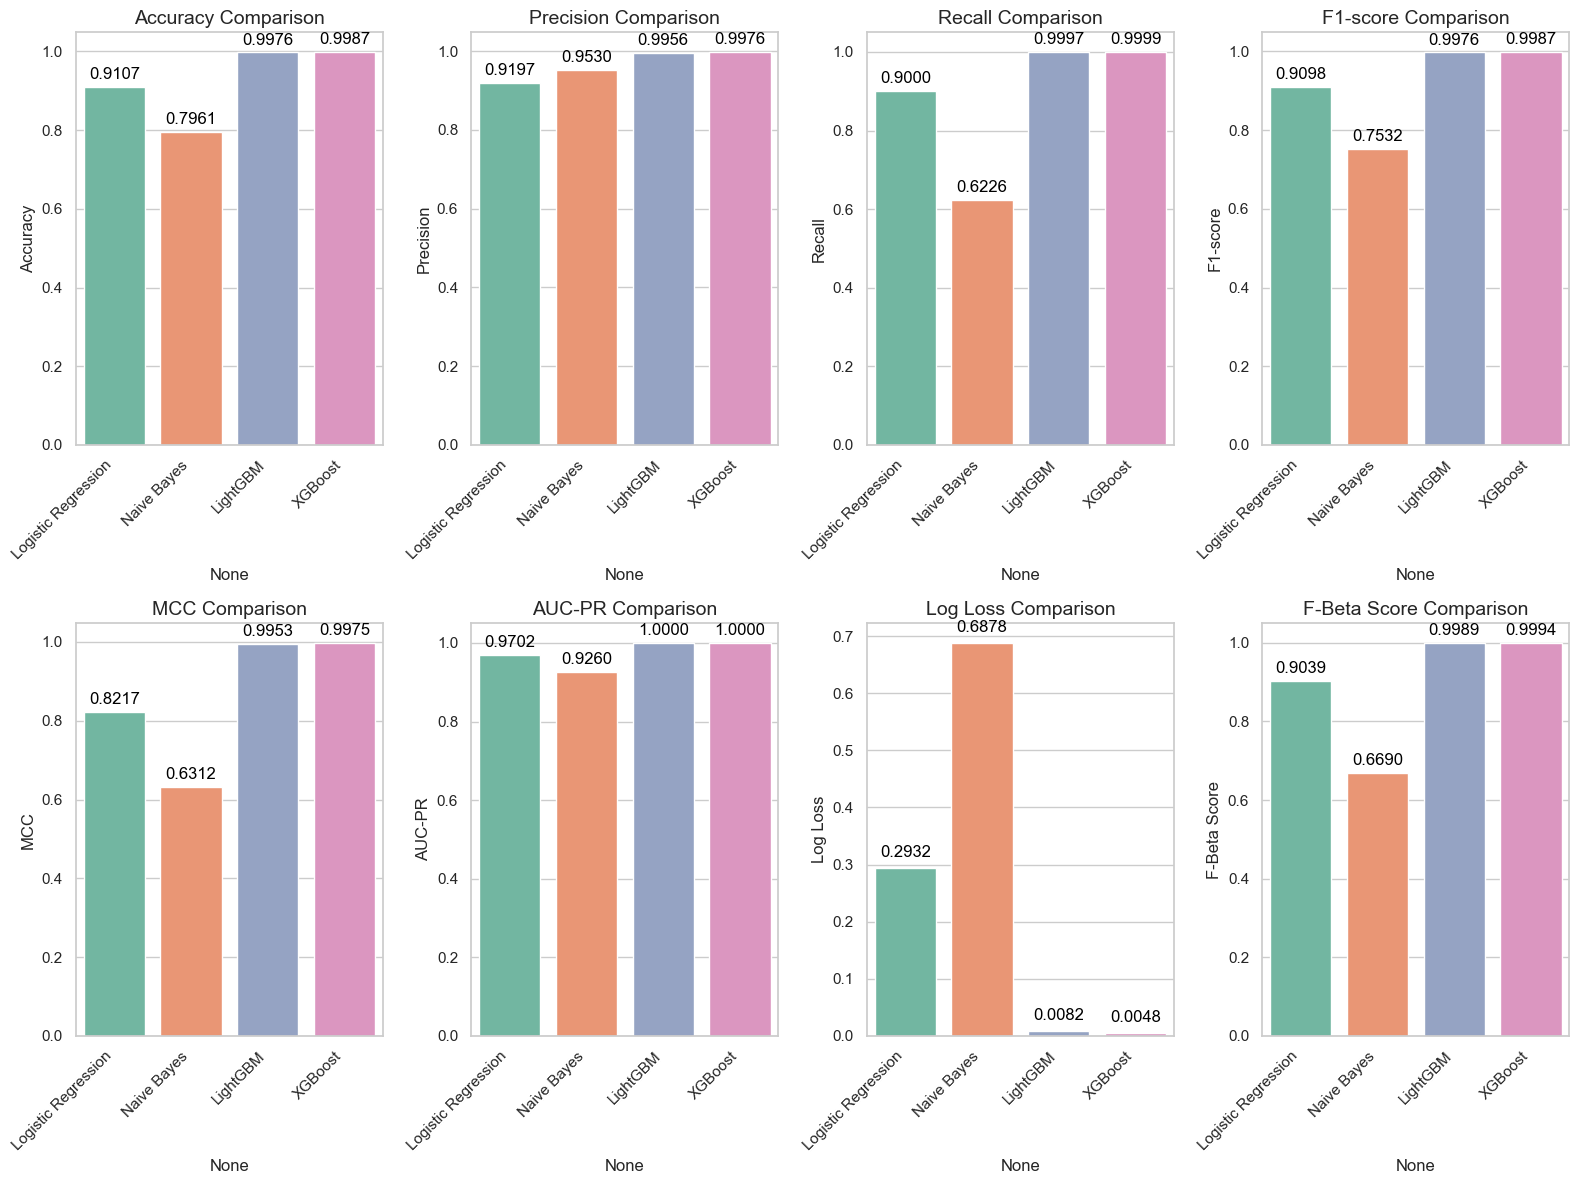

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dati delle metriche per ciascun modello
metrics = {
    'Accuracy': [0.9107, 0.7961, 0.9976, 0.9987],
    'Precision': [0.9197, 0.9530, 0.9956, 0.9976],
    'Recall': [0.9000, 0.6226, 0.9997, 0.9999],
    'F1-score': [0.9098, 0.7532, 0.9976, 0.9987],
    'MCC': [0.8217, 0.6312, 0.9953, 0.9975],
    'AUC-PR': [0.9702, 0.9260, 1.0000, 1.0000],
    'Log Loss': [0.2932, 0.6878, 0.0082, 0.0048],
    'F-Beta Score': [0.9039, 0.6690, 0.9989, 0.9994]
}

# Creare un DataFrame per i dati
df_metrics = pd.DataFrame(metrics, index=['Logistic Regression', 'Naive Bayes', 'LightGBM', 'XGBoost'])

# Configurazione del grafico
plt.figure(figsize=(16, 12))  # Maggiore dimensione della figura

# Creazione dei barplot per ogni metrica
metrics_list = df_metrics.columns
for i, metric in enumerate(metrics_list):
    plt.subplot(2, 4, i+1)
    sns.barplot(x=df_metrics.index, y=df_metrics[metric], palette='Set2')
    
    # Aggiungere le etichette numeriche sopra ogni barra
    for j, value in enumerate(df_metrics[metric]):
        plt.text(j, value + 0.02, f'{value:.4f}', ha='center', fontsize=12, color='black')
    
    # Titoli
    plt.title(f'{metric} Comparison', fontsize=14)
    plt.ylabel(f'{metric}', fontsize=12)
    plt.xticks(rotation=45, ha="right")  # Ruotiamo le etichette per evitare sovrapposizioni

plt.tight_layout()
plt.show()


Colonne nel dataset campionato: Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'balance_diff_orig', 'origin_empty',
       'dest_empty', 'type', 'transfer_to_empty', 'cashout_to_empty',
       'amount_high_risk', 'empty_combo', 'high_risk_empty_combo',
       'amount_zero', 'transfer_origin_empty', 'cashout_zero_amount',
       'transfer_zero_amount', 'cashout_origin_empty', 'transfer_dest_empty',
       'cashin_zero_amount', 'cluster', 'anomaly'],
      dtype='object')


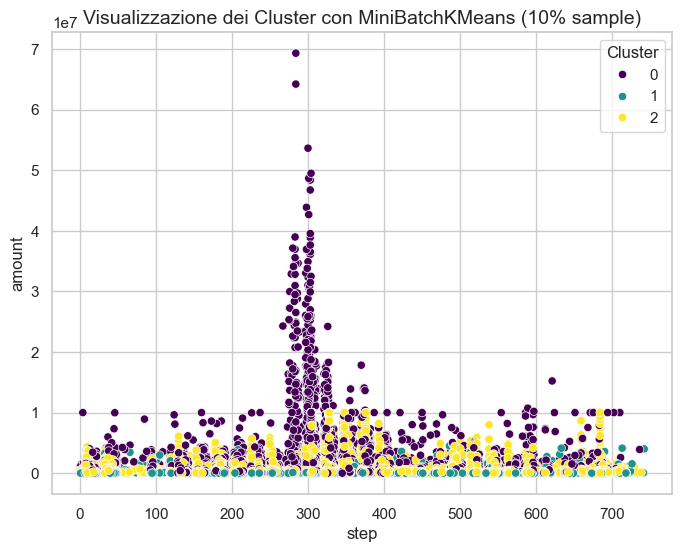

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Campionamento del 10% del dataset
df_sample = df_model.sample(frac=0.1, random_state=42)

# Verifica le colonne disponibili nel dataset campionato
print(f"Colonne nel dataset campionato: {df_sample.columns}")

# Separazione delle feature e del target (rimuoviamo 'isFraud' se presente)
X_sample = df_sample.drop(columns=['isFraud'])

# Controllo delle colonne numeriche presenti nel dataset
numerical_columns = X_sample.select_dtypes(include=['float64', 'int64']).columns

# Selezioniamo solo le colonne numeriche per la visualizzazione
X_numerical = X_sample[numerical_columns]  # Ora prendiamo le colonne numeriche effettive

# One-Hot Encoding per variabili categoriali (es. la colonna 'type')
X_encoded = pd.get_dummies(X_sample, drop_first=True)

# Uniamo le feature numeriche codificate con quelle One-Hot
X_combined = pd.concat([X_numerical, X_encoded], axis=1)

# Standardizzazione delle feature numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Creazione del modello MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=10000)

# Addestramento del modello
mbkmeans.fit(X_scaled)

# Predizione dei cluster
df_sample['Cluster'] = mbkmeans.predict(X_scaled)

# Visualizzazione dei cluster (usiamo le feature originali per il grafico di dispersione)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_sample[numerical_columns[0]], y=df_sample[numerical_columns[1]], hue=df_sample['Cluster'], palette='viridis')
plt.title('Visualizzazione dei Cluster con MiniBatchKMeans (10% sample)', fontsize=14)
plt.xlabel(numerical_columns[0])
plt.ylabel(numerical_columns[1])
plt.legend(title='Cluster', loc='upper right')
plt.show()
